In [6]:
## Overall imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import torch.nn.functional as F
from pathlib import Path
import joblib, json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib.ticker import MultipleLocator
import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [7]:
from modules.data_loader_24h_ import SlidingWindowDataset, PatientLatentDataset
from modules.model_ import PositionalEncoding, CustomTransformerEncoderLayer, VariationalTimeSeriesTransformer, LatentDiscriminator
from modules.train_24h_ import train_model_aae_rollout
from modules.utils_24h_ import extract_latents_by_condition,  normalize_risk_vector, get_risk_from_prediction, get_baseline_prediction_vector, scan_individual_risk, compute_reactivity_score, scan_risk, predict_pollution_level
from modules.visuals_ import evaluate_model_hourly, evaluate_individual_hourly_forecast

In [ ]:
import os

## Downloading from drive shared file 
os.system("pip install gdown")

# Downloading train and test datasets already processed.
# Do you want to see how the data was processed?
# Please go to data_engineering folder and then --> Datapreprocessing.ipynb
# Bear in mind you won't be able to run it since that file was ran on the INHALE data management portal
# I deleted the link to the file since the data is private and sensible
os.system("gdown --id this_is_where_the_link_was --output train_data_not_normalised.csv")
os.system("gdown --id this_is_where_the_link_was--output test_data_not_normalised.csv")


In [ ]:
## Importing train / test / validation
test_data_import = pd.read_csv("test_data_not_normalised.csv")
train_data_nn_pre = pd.read_csv("train_data_not_normalised.csv")
val_data_nn_pre = test_data_import[test_data_import["patient_id"] == 'INH111'].copy()
test_data_nn_pre = test_data_import[test_data_import["patient_id"] != 'INH111'].copy()

print(f"Training Data has unique patient of [{train_data_nn_pre['patient_id'].unique()}]")
print(f"Testing Data has unique patient of [{test_data_nn_pre['patient_id'].unique()}]")
print(f"Validation Data has unique patient of [{val_data_nn_pre['patient_id'].unique()}]")
print(len(train_data_nn_pre), len(test_data_nn_pre), len(val_data_nn_pre))
print(len(train_data_nn_pre["patient_id"].unique()), len(test_data_nn_pre["patient_id"].unique()), len(val_data_nn_pre["patient_id"].unique()))

In [12]:
train_data_nn = train_data_nn_pre.copy()
test_data_nn = test_data_nn_pre.copy()

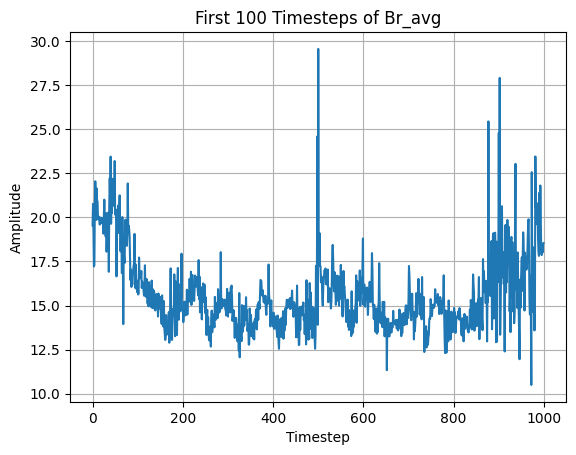

In [ ]:
first_patient = train_data_nn[train_data_nn['patient_id'] == 'first_patient_id']
plt.plot(first_patient['br_avg'][:1000])
plt.title("First 100 Timesteps of Br_avg")
plt.xlabel("Timestep")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [15]:
# Features to include in the model
feature_cols = ['br_avg','br_std','act_level','step_count','pm2_5_x','temperature',
    'humidity','hour_sin','hour_cos','dow_sin','dow_cos','yearly_sin',
    'yearly_cos','lat_round','lon_round','pm10','no','no2','o3','so2','co',
    'inhale_tv']

# Sampling and Horizons
sampling_interval = 60   # 1 row = 60 min = 1 hour
history_hours     = 1    # use last 1 h
forecast_hours    = 12    # predict next x h
block_minutes     = 60   # predict in 60 min (=1 h) chunks

# Converting here 1 1 12 12
window_size = history_hours * 60 // sampling_interval   # 60/60 = 1 row in
block_size  = block_minutes    // sampling_interval       # 60/60 = 1 row out
num_blocks  = (forecast_hours * 60) // block_minutes     # (6*60)/60 = 12 blocks
horizon     = block_size * num_blocks                    # 1 * 6 = 6 rows ahead

print("window_size, block_size, num_blocks, horizon:",
      window_size, block_size, num_blocks, horizon)
# → window_size=1, block_size=1, num_blocks=6, horizon=6

# Hyperparameters
batch_size      = 64
d_model         = 64
nhead           = 4
num_layers      = 3
dim_feedforward = 128
dropout         = 0.1
lr              = 1e-3
epochs          = 3
device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data prep
# assume train_data_nn_pre/test_data_nn_pre are already loaded DataFrames
data_train = train_data_nn_pre[feature_cols]
data_test  = test_data_nn_pre[feature_cols]

scaler = MinMaxScaler()
scaler.fit(data_train)              # fit on train only
train_scaled = scaler.transform(data_train)
test_scaled  = scaler.transform(data_test)

# Creating sliding‐window datasets (1 h in → 6 h out)
train_dataset = SlidingWindowDataset(train_scaled, window_size = window_size, forecast_steps = horizon, step = 1)
test_dataset = SlidingWindowDataset(test_scaled, window_size = window_size, forecast_steps = horizon, step = 1)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# This is useful if you want to run entire model from scratch (estimated time 1h)
# # Model & discriminator
# model = VariationalTimeSeriesTransformer(
#     input_features   = len(feature_cols),
#     d_model           = d_model,
#     nhead             = nhead,
#     num_layers        = num_layers,
#     dim_feedforward   = dim_feedforward,
#     dropout           = dropout,
#     forecast_steps    = block_size,    # =1 → 1 h per forward
#     output_features   = len(feature_cols)
# ).to(device)

# discriminator = LatentDiscriminator(latent_dim=model.latent_dim).to(device)
# optimizer      = torch.optim.Adam(model.parameters(),       lr=lr)
# disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

# # # Training with block-wise rollout
# train_model_aae_rollout(
#     model                    = model,
#     train_loader             = train_loader,
#     val_loader               = test_loader,
#     optimizer                = optimizer,
#     discriminator            = discriminator,
#     disc_optimizer           = disc_optimizer,
#     device                   = device,
#     epochs                   = epochs,
#     adv_weight               = 0.01,
#     scheduled_sampling_start = 1.0,
#     scheduled_sampling_end   = 0.5,
#     scheduled_sampling_decay = 0.9,
#     block_size               = block_size,   # =1
#     num_blocks               = num_blocks    # =6
# )

window_size, block_size, num_blocks, horizon: 1 1 12 12


In [ ]:
## SAVING THE MODEL AND ALL DEPENDENCIES

from pathlib import Path
import torch, joblib, json

RUN_DIR = Path("/content/drive/MyDrive/vae_forecaster_v1")
RUN_DIR.mkdir(parents=True, exist_ok=True)

# 1) Save model weights
torch.save(model.state_dict(), RUN_DIR / "model_state.pt")

# 2) Save scaler (used for preprocessing & inverse_transform)
joblib.dump(scaler, RUN_DIR / "scaler.pkl")

# 3) Save config (so you can rebuild the model identically)
config = {
    "feature_cols": feature_cols,           # feature order is critical
    "window_size": window_size,
    "block_size": block_size,
    "num_blocks": num_blocks,
    "horizon": horizon,
    "model_hparams": {
        "input_features": len(feature_cols),
        "d_model": d_model,
        "nhead": nhead,
        "num_layers": num_layers,
        "dim_feedforward": dim_feedforward,
        "dropout": dropout,
        "forecast_steps": block_size,       # must match training
        "output_features": len(feature_cols),
        "latent_dim": getattr(model, "latent_dim", 64),
    }
}

with open(RUN_DIR / "config.json", "w") as f:
    json.dump(config, f, indent=2)

print(f"✅ Saved model, scaler, and config to {RUN_DIR}")


In [17]:

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models saved in the model folder
RUN_DIR = Path("models/")

# Loading scaler
scaler = joblib.load(RUN_DIR / "scaler.pkl")

# Loading configuration (hyperparameters)
with open(RUN_DIR / "config.json") as f:
    cfg = json.load(f)

# Rebuilding model architecture
mh = cfg["model_hparams"]
model = VariationalTimeSeriesTransformer(**mh).to(DEVICE)

# Loading trained weights
state = torch.load(RUN_DIR / "model_state.pt", map_location=DEVICE)
model.load_state_dict(state)
model.eval()

VariationalTimeSeriesTransformer(
  (input_proj): Linear(in_features=22, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-2): 3 x CustomTransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (linear1): Linear(in_features=64, out_features=128, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=128, out_features=64, bias=True)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (mean_layer): Linear(in_features=64, out_features=64, bias=True)
  (logvar_layer): Linear(in_features=64, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bi

In [18]:
discriminator = LatentDiscriminator(latent_dim=model.latent_dim).to(device)
optimizer      = torch.optim.Adam(model.parameters(),       lr=lr)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

## Plotting Model Results

In [19]:
# Plotting model results - hourly level

# Run hourly evaluation
preds_hourly, trues_hourly = evaluate_model_hourly(
    model=model,
    dataloader=test_loader,
    device=device,
    scaler=scaler,
    feature_names=feature_cols
)
# Hourly-level metrics
print("\nHourly Aggregated Metrics:")
print(f"MSE: {mean_squared_error(trues_hourly, preds_hourly):.4f}")
print(f"MAE: {mean_absolute_error(trues_hourly, preds_hourly):.4f}")
print(f"R² Score: {r2_score(trues_hourly, preds_hourly):.4f}")

# Per-feature metrics
print("\nPer-feature Hourly Metrics:")
for i, feature in enumerate(feature_cols):
    mse = mean_squared_error(trues_hourly[:, i], preds_hourly[:, i])
    mae = mean_absolute_error(trues_hourly[:, i], preds_hourly[:, i])
    r2 = r2_score(trues_hourly[:, i], preds_hourly[:, i])
    print(f"{feature}:")
    print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


Hourly Aggregated Metrics:
MSE: 13.6993
MAE: 1.0952
R² Score: 0.8879

Per-feature Hourly Metrics:
br_avg:
  MSE: 0.3788, MAE: 0.4584, R²: 0.8156
br_std:
  MSE: 0.2509, MAE: 0.3604, R²: 0.8136
act_level:
  MSE: 0.0001, MAE: 0.0054, R²: 0.8229
step_count:
  MSE: 9.2725, MAE: 1.2396, R²: 0.6566
pm2_5_x:
  MSE: 22.3740, MAE: 3.0890, R²: 0.9252
temperature:
  MSE: 0.5076, MAE: 0.5440, R²: 0.9620
humidity:
  MSE: 0.7199, MAE: 0.6675, R²: 0.9851
hour_sin:
  MSE: 0.0043, MAE: 0.0378, R²: 0.9893
hour_cos:
  MSE: 0.0064, MAE: 0.0486, R²: 0.9850
dow_sin:
  MSE: 0.0026, MAE: 0.0243, R²: 0.9946
dow_cos:
  MSE: 0.0028, MAE: 0.0225, R²: 0.9944
yearly_sin:
  MSE: 0.0038, MAE: 0.0205, R²: 0.9926
yearly_cos:
  MSE: 0.0027, MAE: 0.0419, R²: 0.9937
lat_round:
  MSE: 0.0135, MAE: 0.0128, R²: 0.3813
lon_round:
  MSE: 0.0027, MAE: 0.0242, R²: 0.6148
pm10:
  MSE: 1.1893, MAE: 0.6134, R²: 0.9723
no:
  MSE: 23.7358, MAE: 1.6767, R²: 0.9183
no2:
  MSE: 5.2336, MAE: 2.0028, R²: 0.9704
o3:
  MSE: 20.3503, MAE: 3.

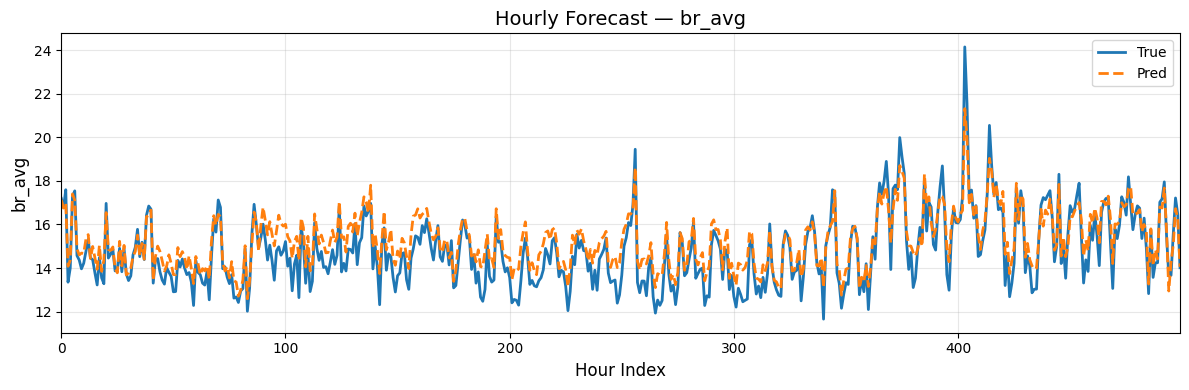

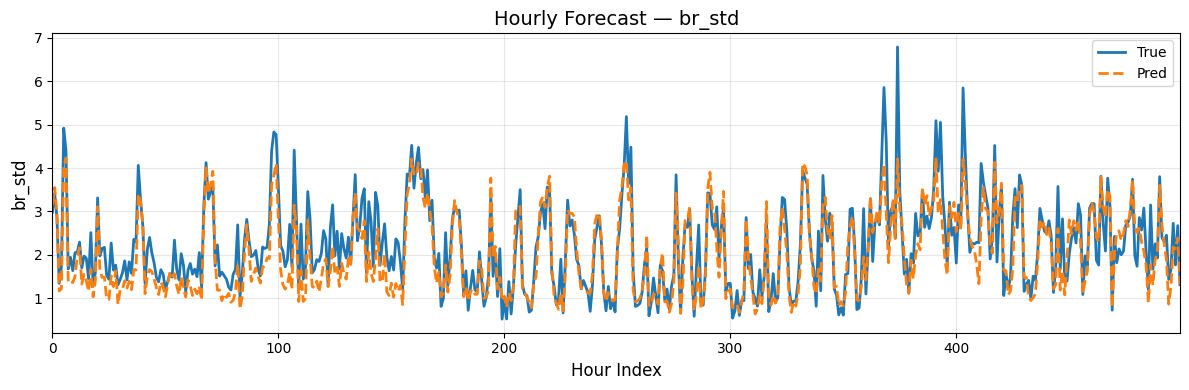

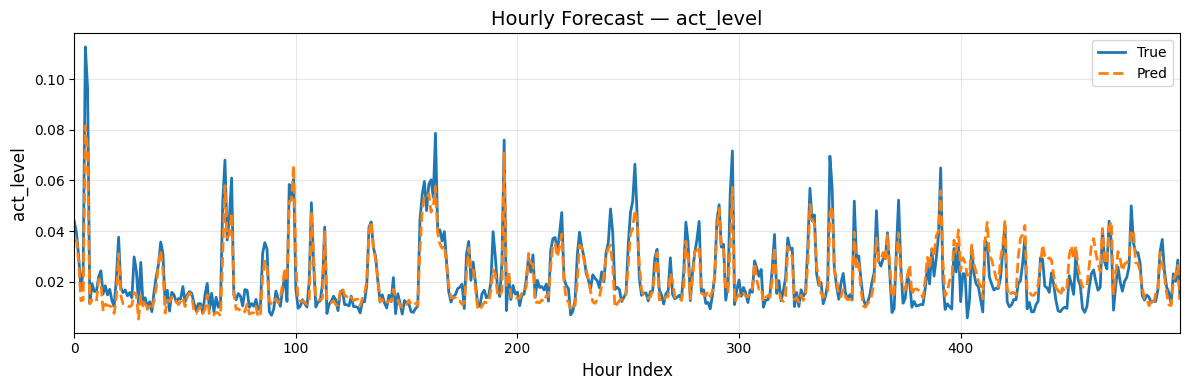

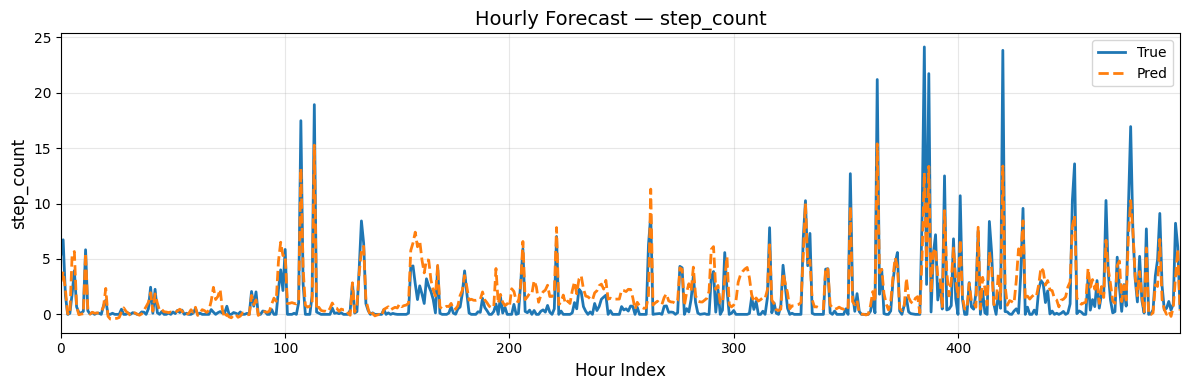

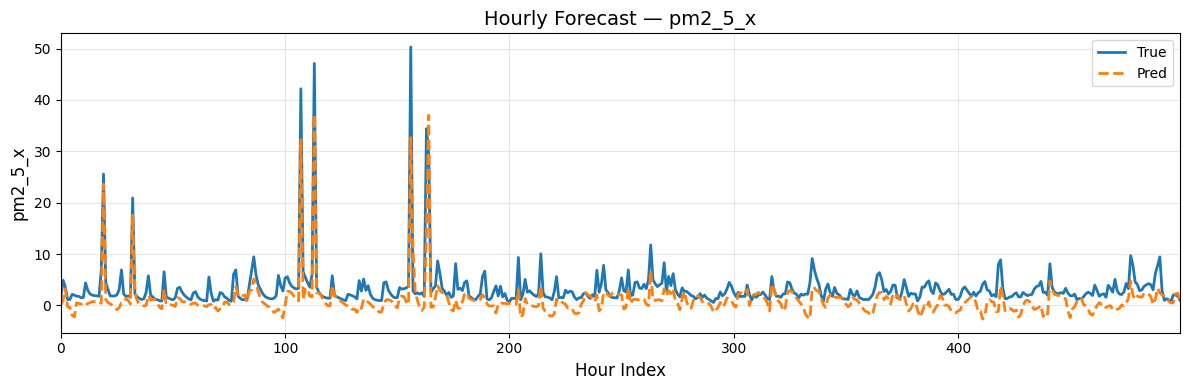

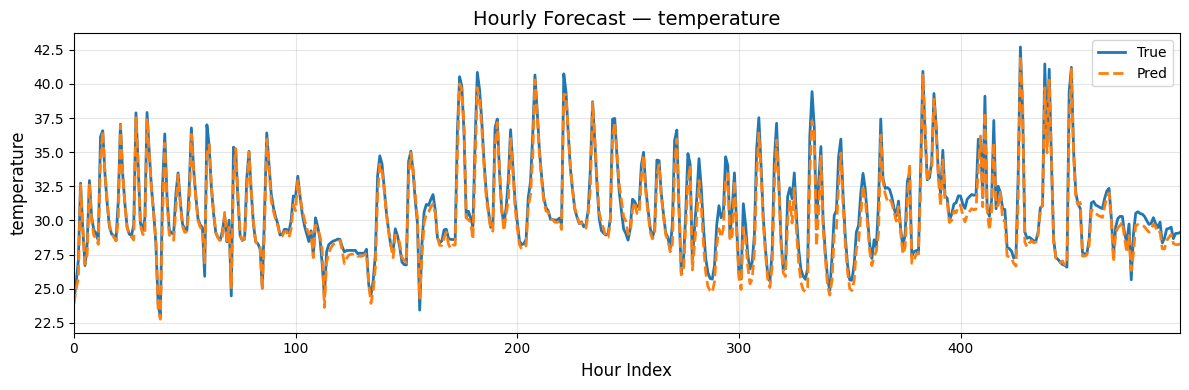

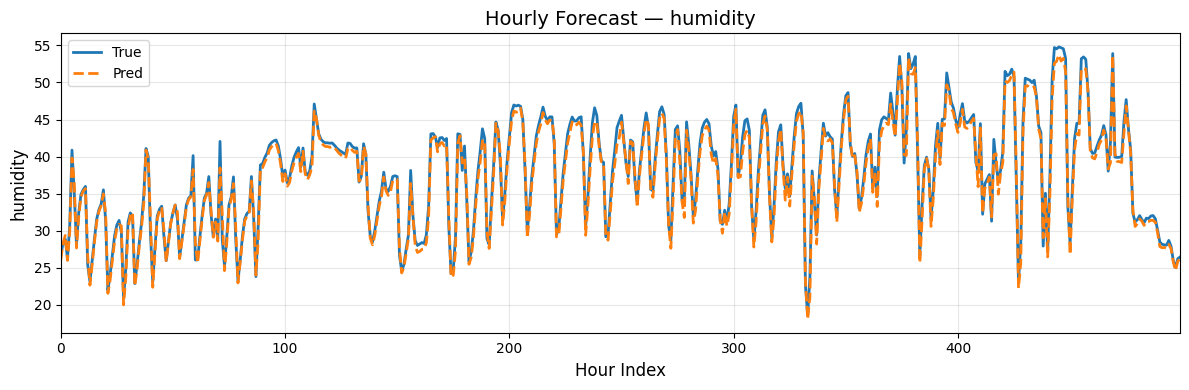

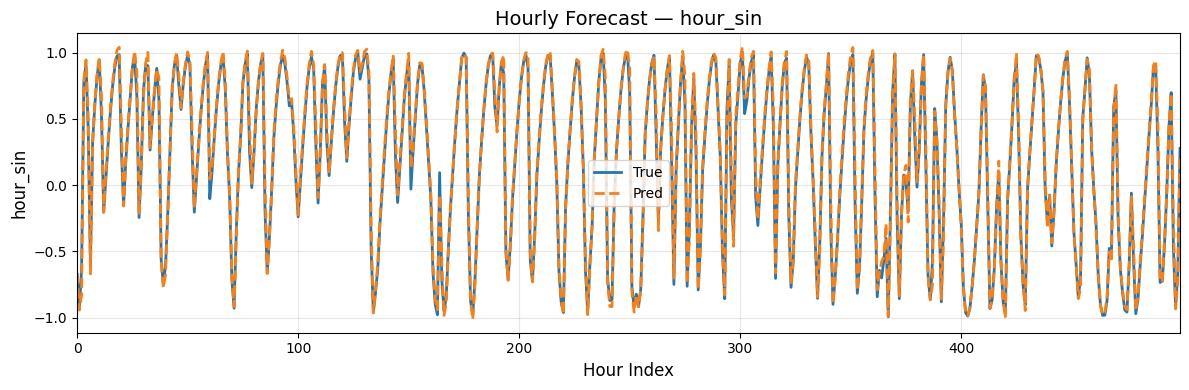

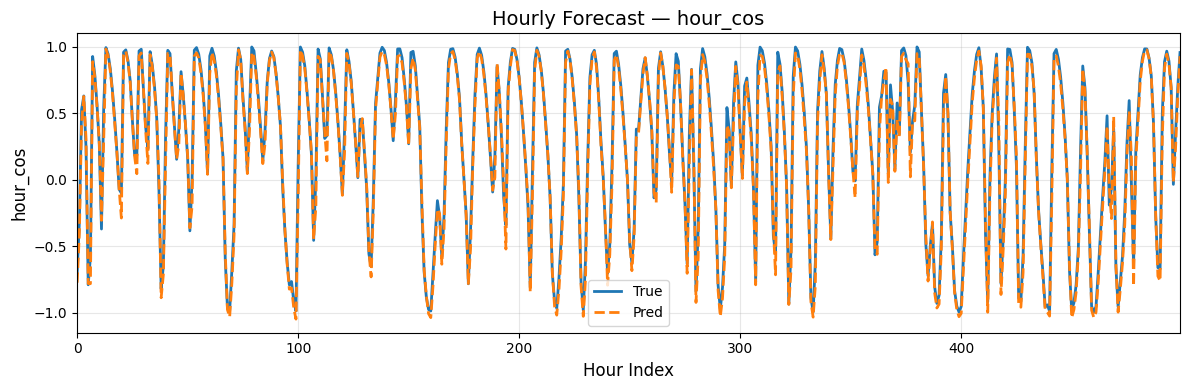

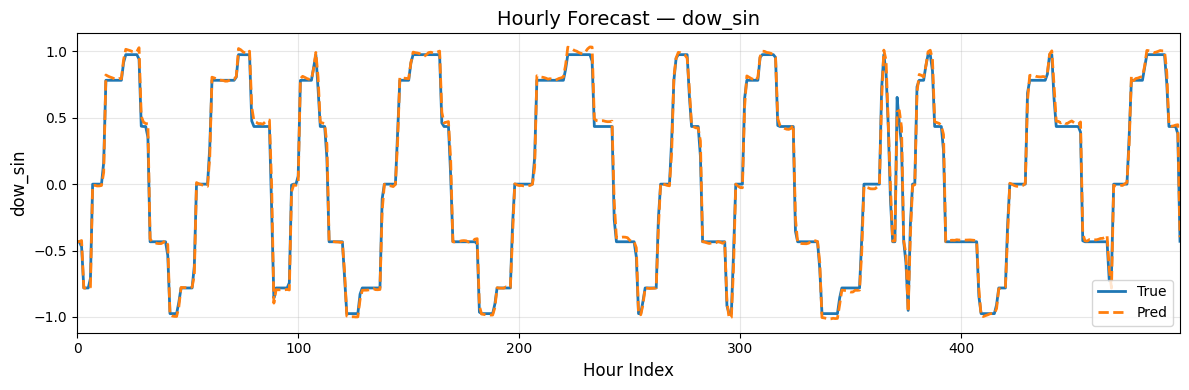

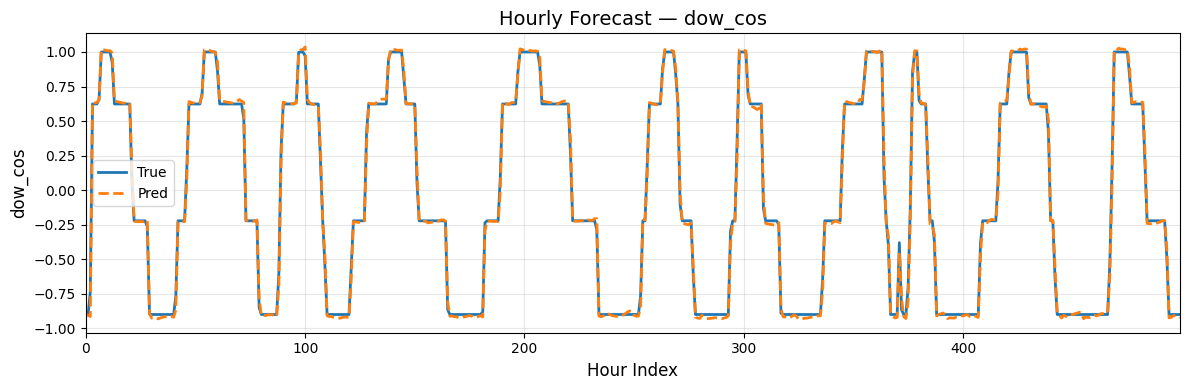

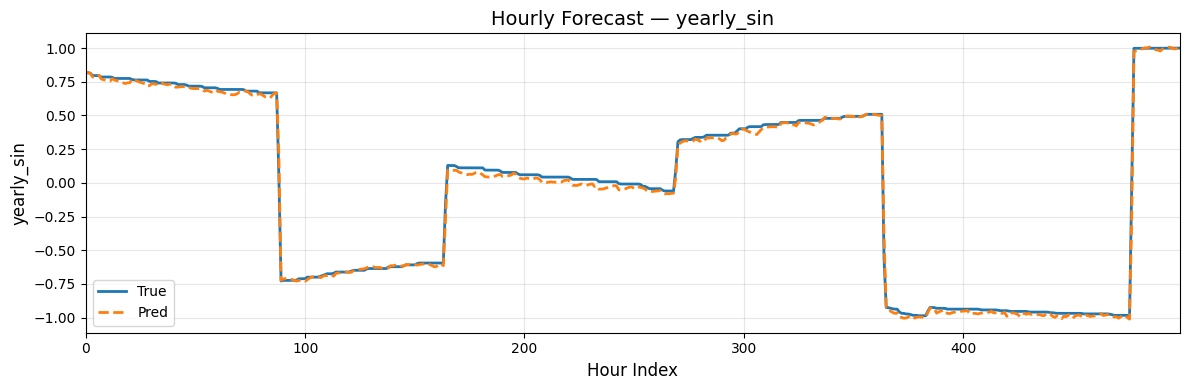

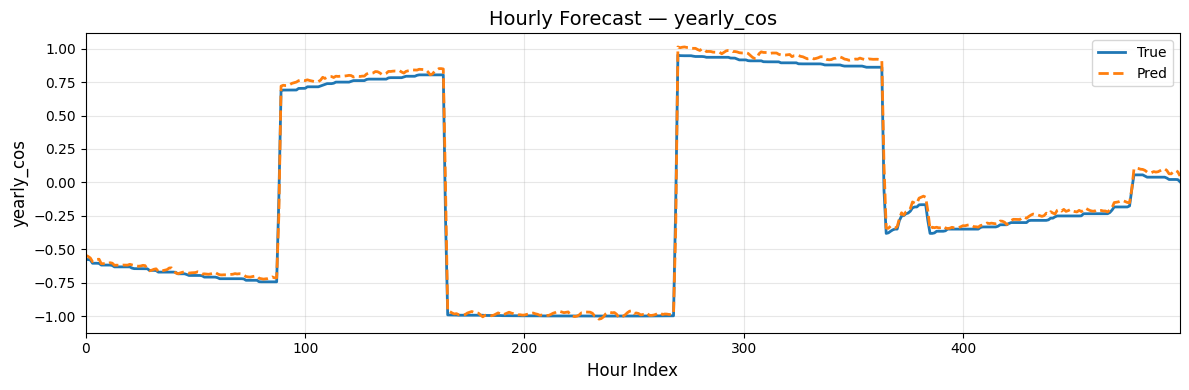

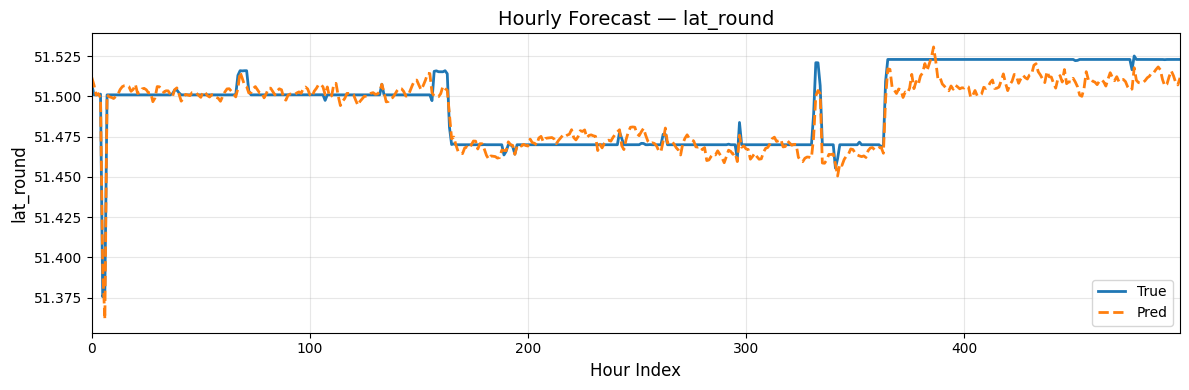

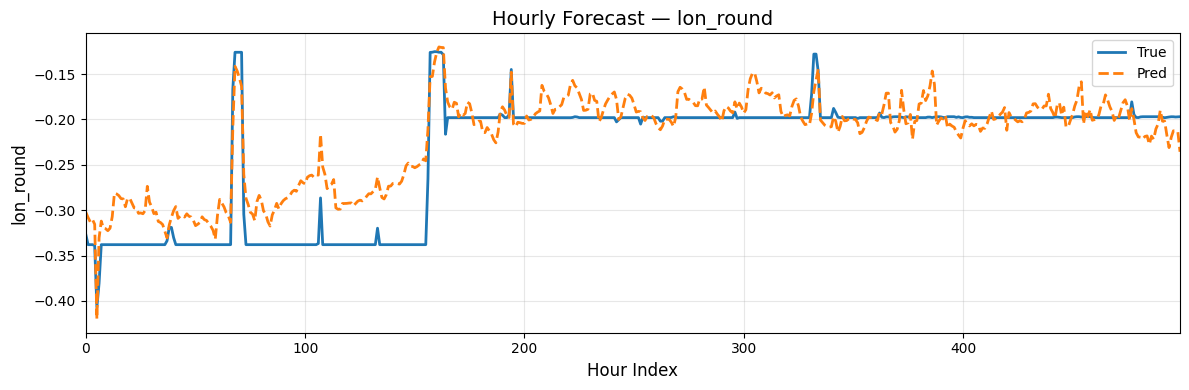

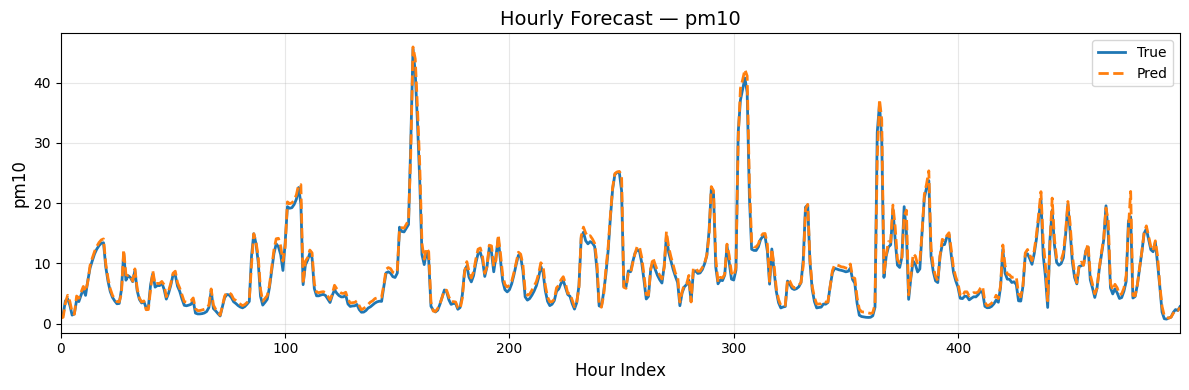

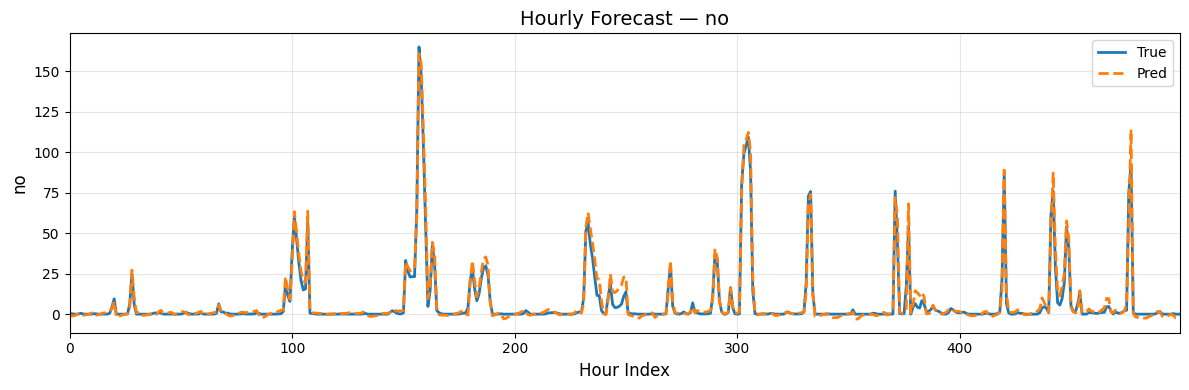

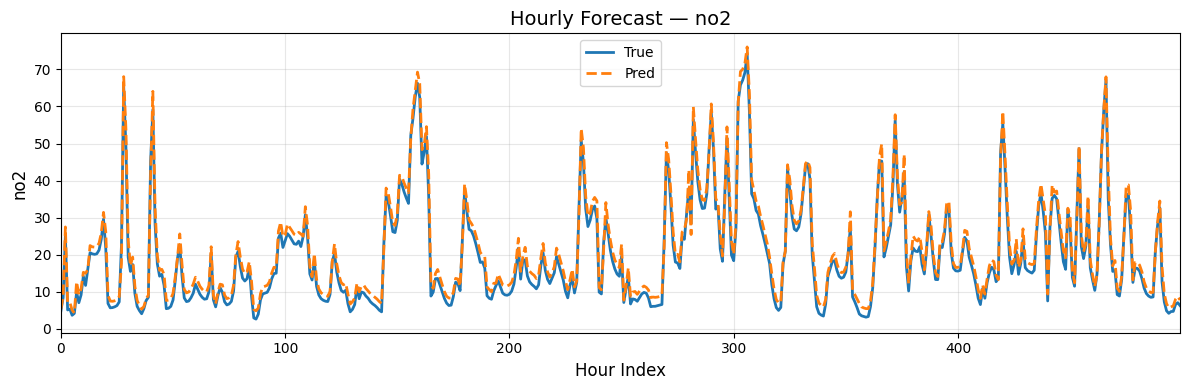

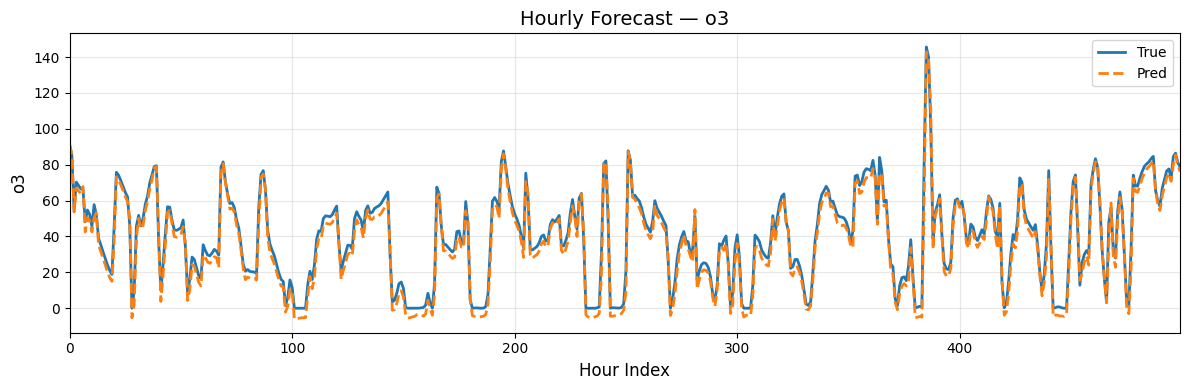

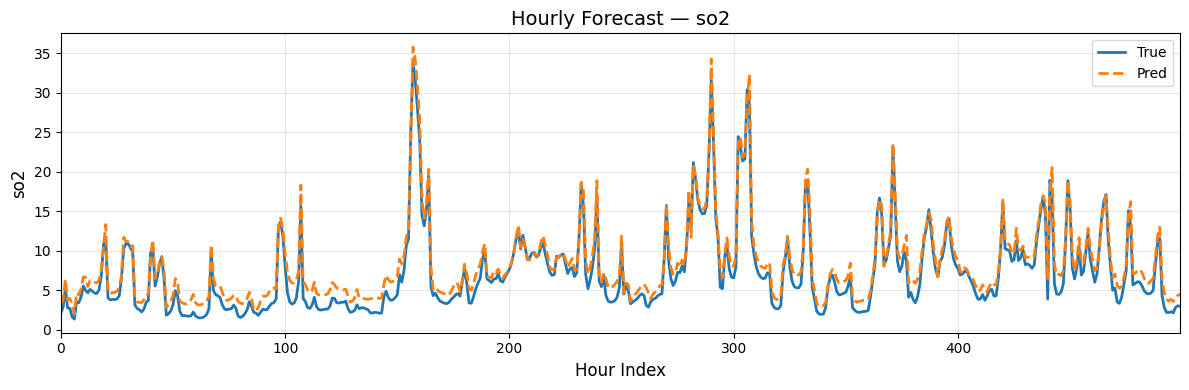

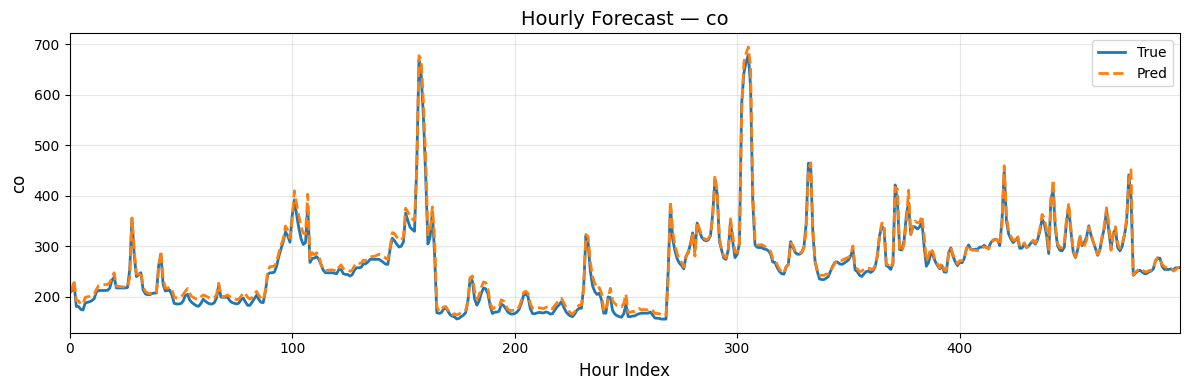

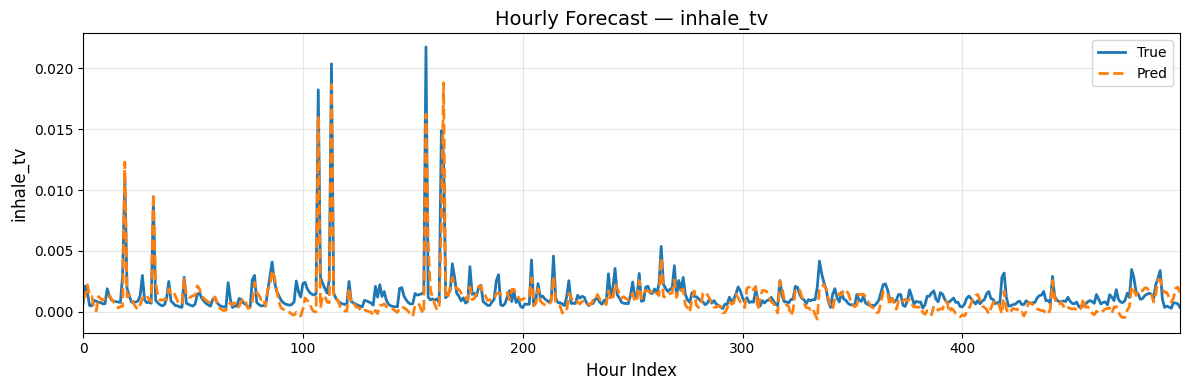

In [20]:
# Showing the first 500 points
max_pts = 500

# preds_hourly, trues_hourly: both are (n_hours, n_feats)
n_hours, n_feats = preds_hourly.shape
hours = np.arange(n_hours)
## this is so we don't go over the end in time
end = min(max_pts, n_hours)

for i, feat in enumerate(feature_cols):
    plt.figure(figsize=(12, 4))
    plt.plot(hours[:end], trues_hourly[:end, i], label='True',color='tab:blue', linewidth=2)
    plt.plot(hours[:end], preds_hourly[:end, i], label='Pred', color='tab:orange', linestyle='--', linewidth=2)
    plt.title(f'Hourly Forecast — {feat}', fontsize=14)
    plt.xlabel('Hour Index', fontsize=12)
    plt.ylabel(feat, fontsize=12)
    plt.xlim(0, end-1)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## Model Analysis

## How do individuals tend to react to pollution based on their latent space?

In [21]:
forecast_steps = horizon
## Here I am concatenating train and test data - useful because I will then extract the latent
combined = pd.concat([train_data_nn_pre, test_data_nn_pre])
combined_pert = pd.concat([train_data_nn_pre, test_data_nn_pre])

In [22]:
latent_dataset = PatientLatentDataset(combined, feature_cols, scaler, window_size, forecast_steps)
latent_loader = DataLoader(latent_dataset, batch_size=64, shuffle=False)

## Passing the created combined dataset to the encoder and extractign a latent vector z
## Returning 2 dataframes, z_df as latent_vectors, while meta_df as metadata

z_df, meta_df = extract_latents_by_condition(model, latent_loader, device)

## Combining patient ID + z vectors
df_latent = pd.concat([meta_df.reset_index(drop=True), z_df], axis=1)

# the final dataframe of patient_id with latent_vectors
agg_all = df_latent.groupby('patient_id')[z_df.columns].mean()

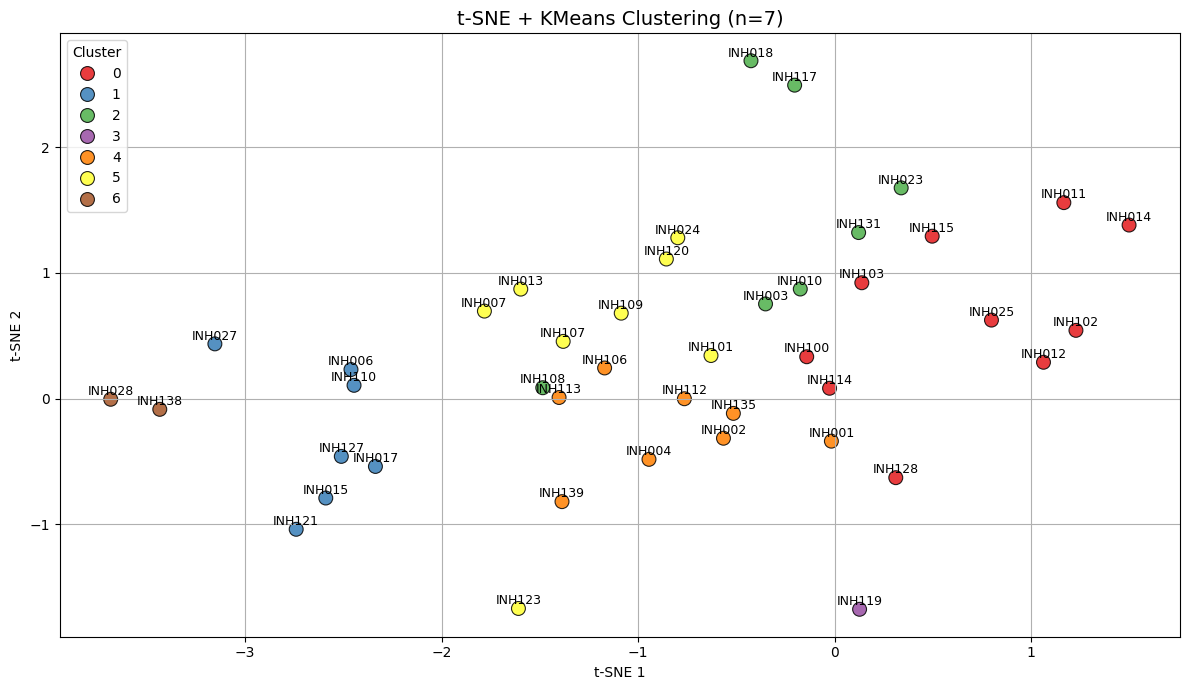

In [33]:
# This is for clustering all individuals
# Scaling the latent space
X = agg_all.values

X_scaled = StandardScaler().fit_transform(X)

# Storing IDs
patient_ids = agg_all.index

# Running t-SNE with exact method to make it deterministic
tsne = TSNE(n_components=2, perplexity = 25,method = "exact", random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Running KMeans on same scaled data (not on t-SNE)
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
cluster_labels = kmeans.fit_predict(X_scaled)

# Adding cluster info to original data
agg_all['cluster'] = cluster_labels

# Create plotting DataFrame with dimensionality reduction techinque, cluster and checking which id belongs to which cluster
df_plot = pd.DataFrame({'TSNE1': X_tsne[:, 0], 'TSNE2': X_tsne[:, 1], 'cluster': cluster_labels,'patient_id': patient_ids})

# Plotting
plt.figure(figsize=(12, 7))
sns.scatterplot(x='TSNE1', y='TSNE2',hue='cluster',data=df_plot,palette='Set1',s=100,alpha=0.85,edgecolor='black')

# Adding patient_id on top of each dot
# this was originally done to see if they are healthy or ashmatic but still useful
for _, row in df_plot.iterrows():
    plt.text(row['TSNE1'],row['TSNE2'] + 0.01,str(row['patient_id']),fontsize=9,ha='center',va='bottom')

plt.title(f"t-SNE + KMeans Clustering (n={n_clusters})", fontsize=14)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.legend(title='Cluster')
plt.show()

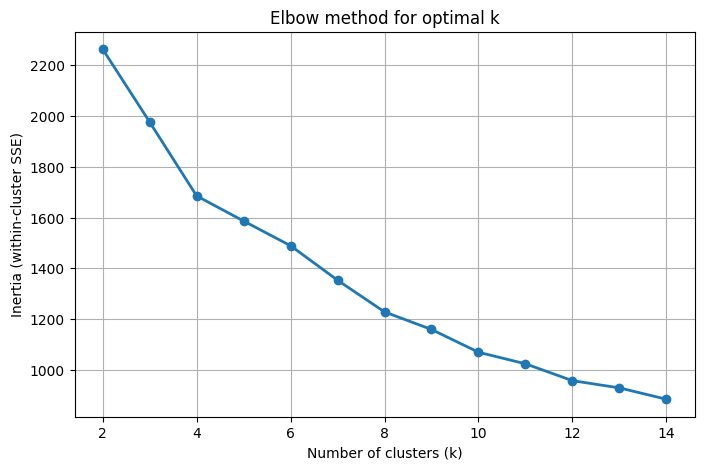

In [34]:
## Elbow plot
## Decided to go for 7 clusters because I want to be able to understand small differences between clusters

X_scaled_elbow = StandardScaler().fit_transform(agg_all.values)

inertias = []
K = range(2, 15)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_scaled_elbow)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'o-', linewidth=2)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow method for optimal k")
plt.grid(True)
plt.show()


In [36]:
# Here I will map each patient to the cluster I found
# Meta_clustered is the result of the merge between meta_df metadata with the corresponding cluster
meta_clustered = meta_df.merge(agg_all[['cluster']],left_on='patient_id', right_index=True,how='left')

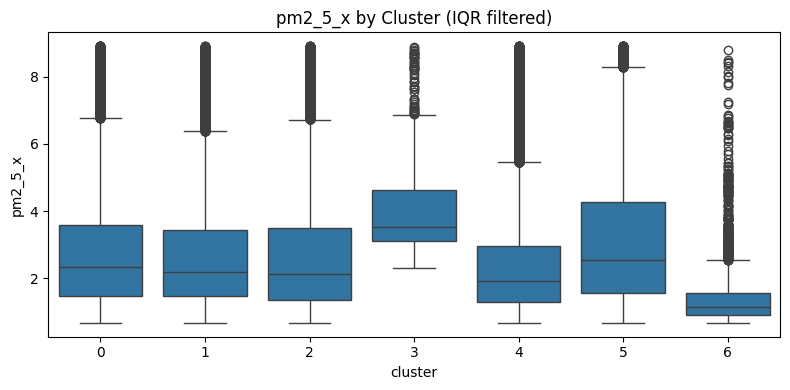

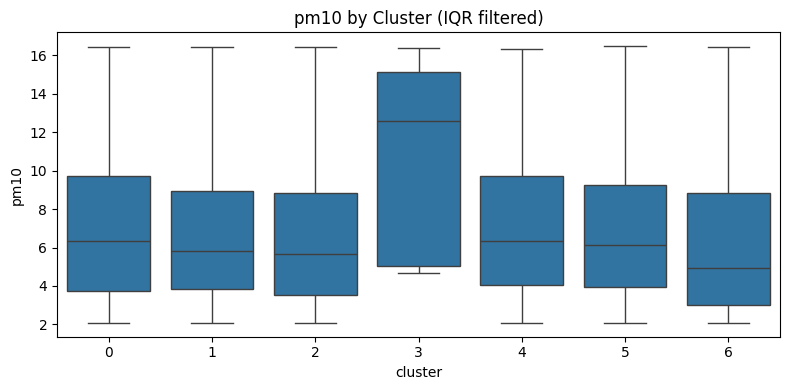

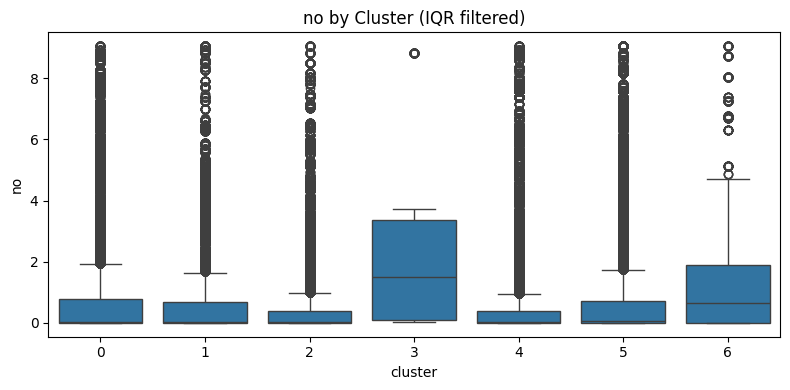

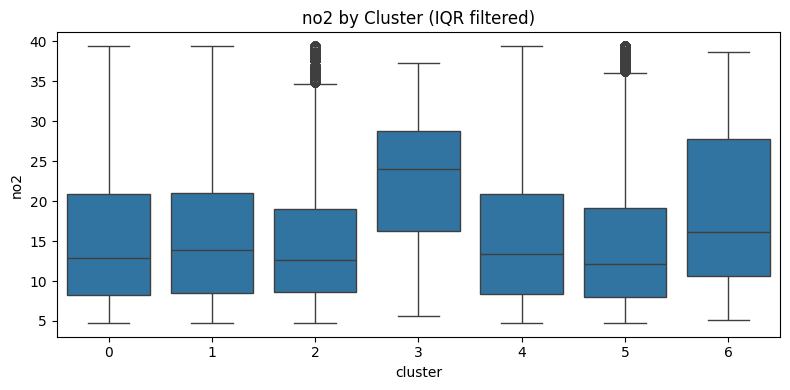

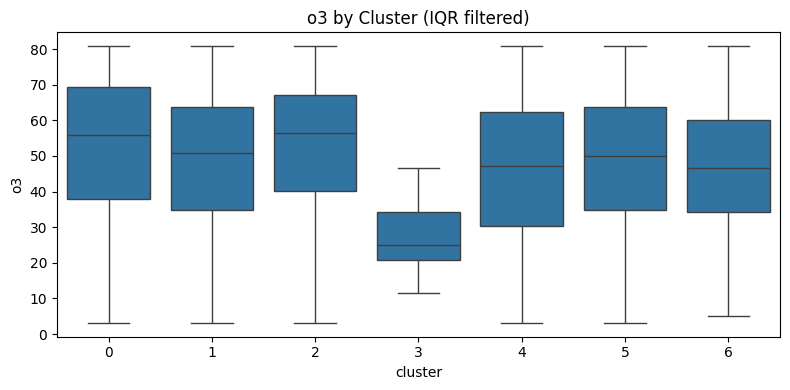

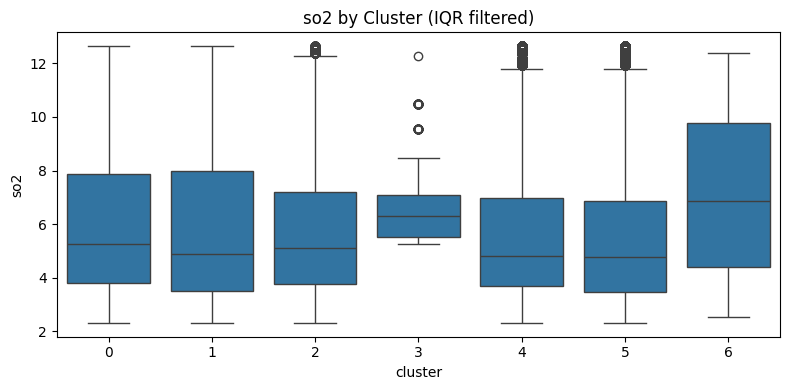

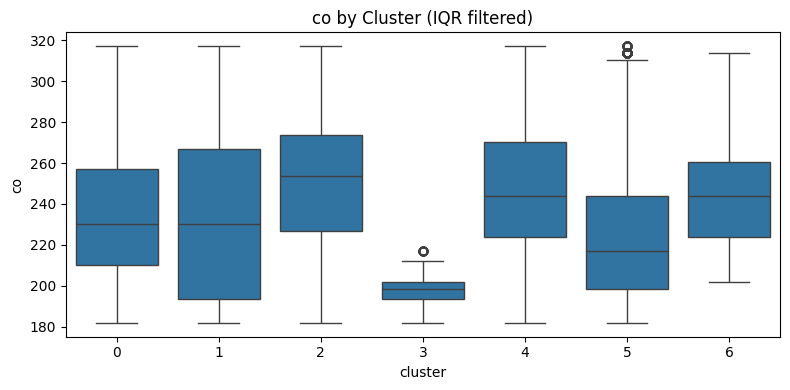

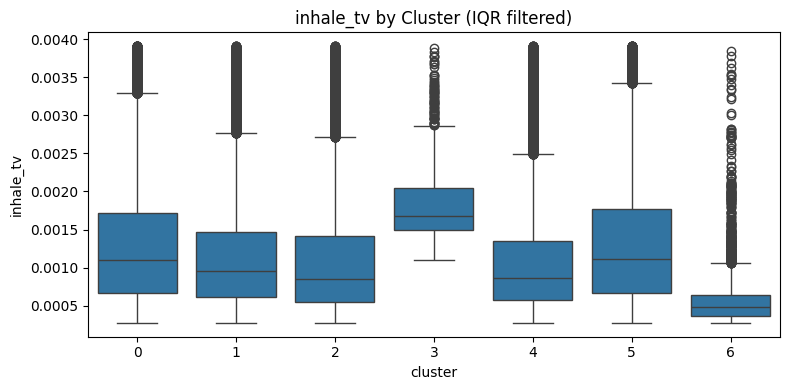

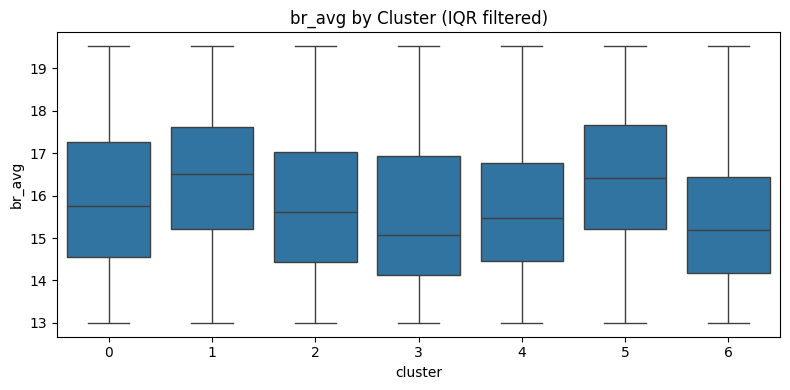

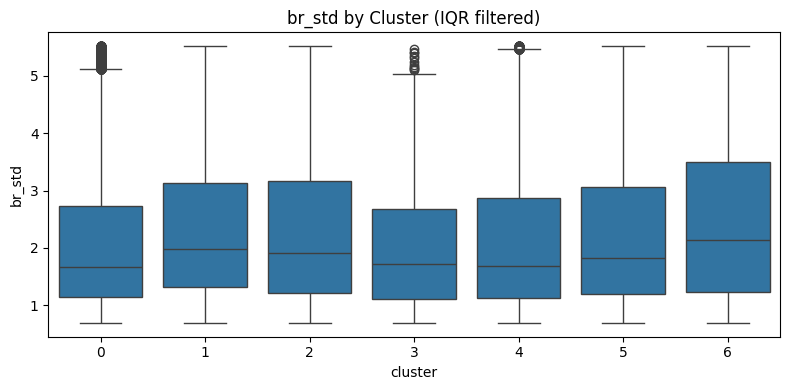

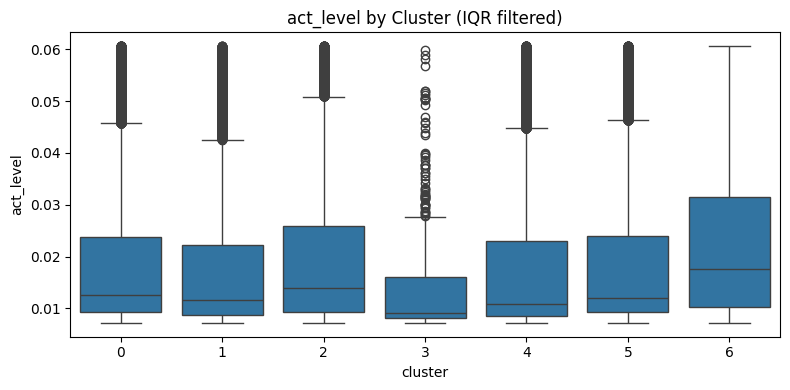

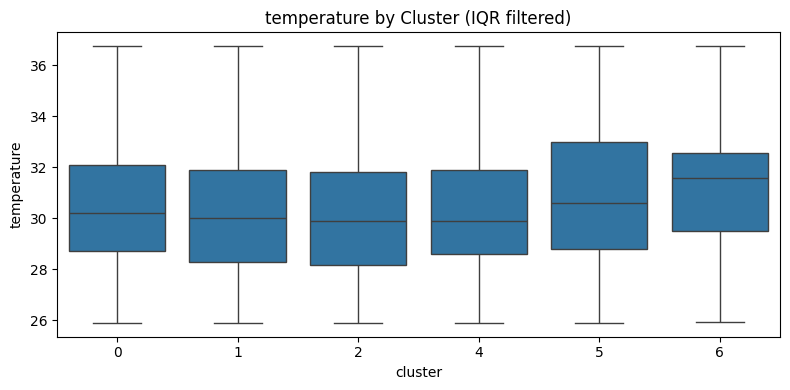

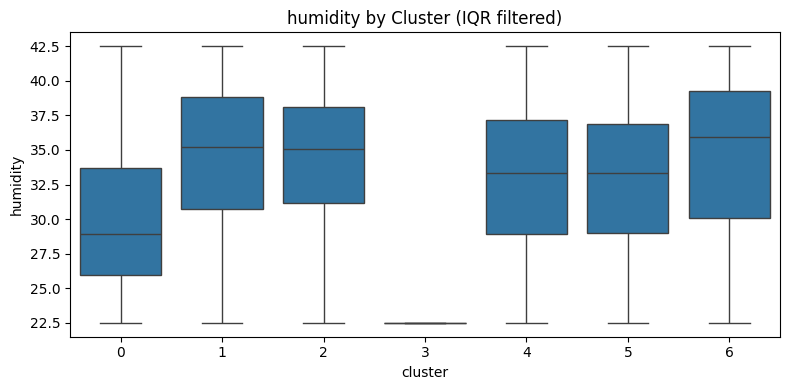

In [ ]:
## let's create boxplot per cluster so we are able to see how their distribution and median differ from one other
data_clustered = meta_clustered.copy()

features = ['pm2_5_x', 'pm10', 'no', 'no2', 'o3', 'so2', 'co', 'inhale_tv', 'br_avg', 'br_std', 'act_level', 'temperature', 'humidity']

for col in features:
    # Computing IQR (Interquartile Range)
    Q1 = data_clustered[col].quantile(0.10)
    Q3 = data_clustered[col].quantile(0.90)
    IQR = Q3 - Q1

    # Keeping only data within the IQR (optionally expand range slightly, e.g. 1.5 * IQR)
    lower = Q1
    upper = Q3
    filtered_df = data_clustered[(data_clustered[col] >= lower) & (data_clustered[col] <= upper)]

    plt.figure(figsize=(8, 4))
    sns.boxplot(x='cluster', y=col, data=filtered_df)
    plt.title(f"{col} by Cluster (IQR filtered)")
    plt.tight_layout()
    plt.show()


## Ashmatic vs Healthy Individuals

status
Asthmatic    19
Control      24
Name: patient_id, dtype: int64
status
Control      324251
Asthmatic    161656
Name: count, dtype: int64


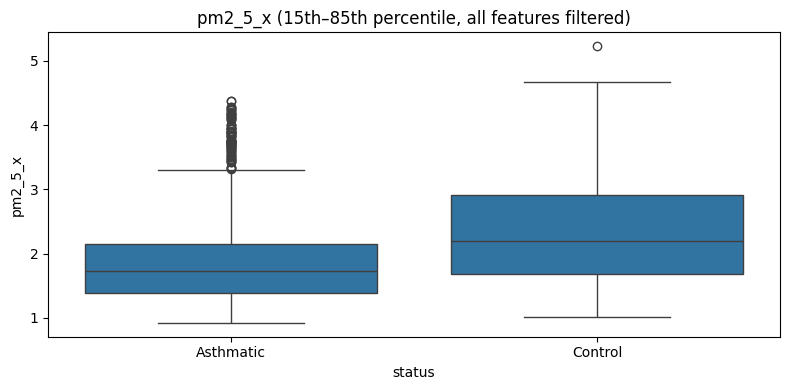

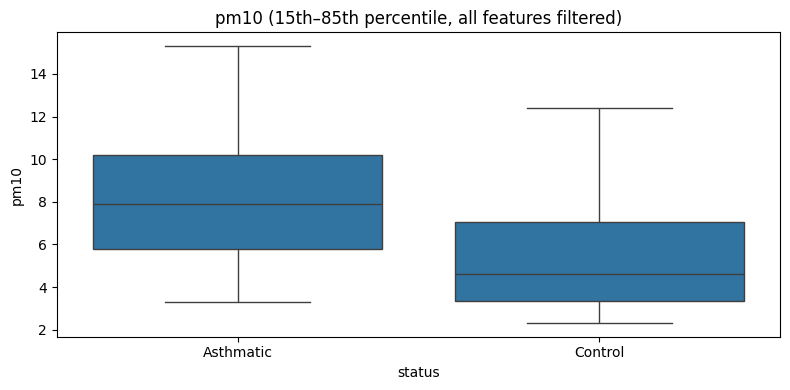

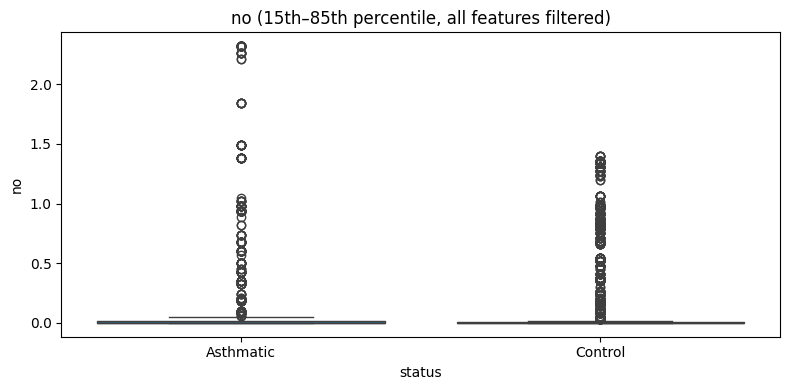

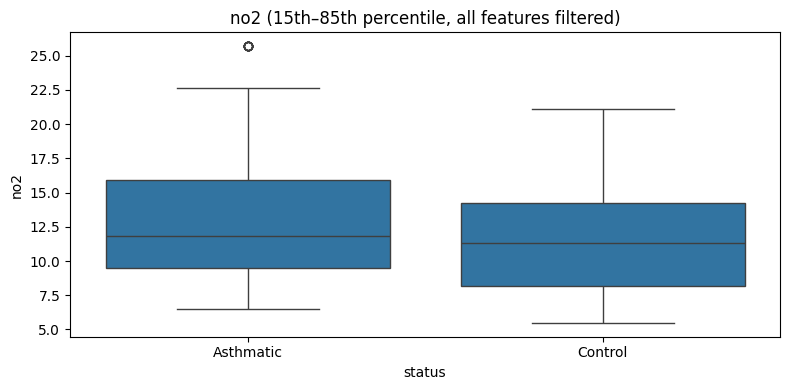

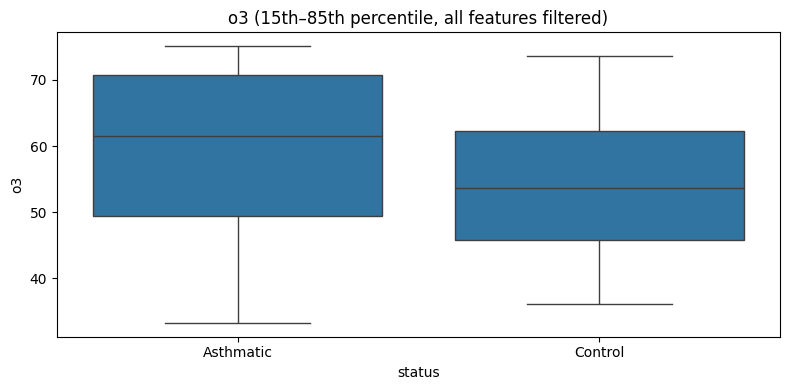

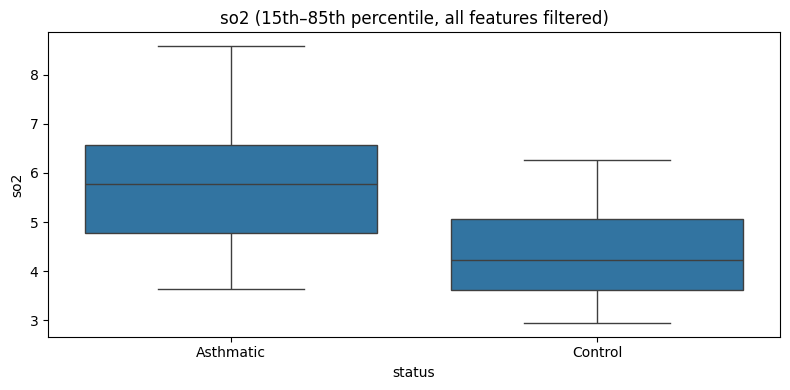

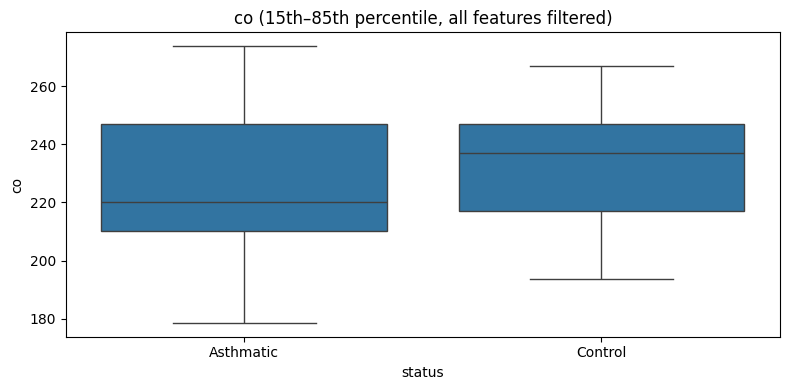

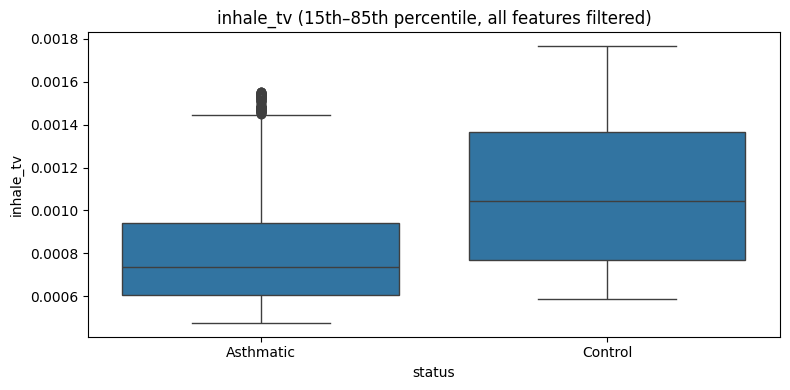

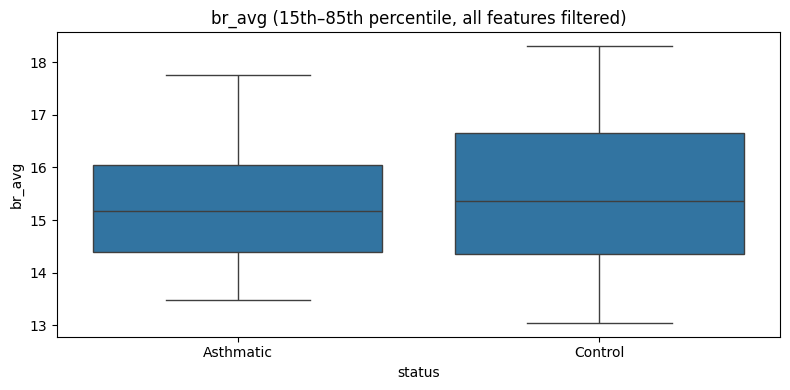

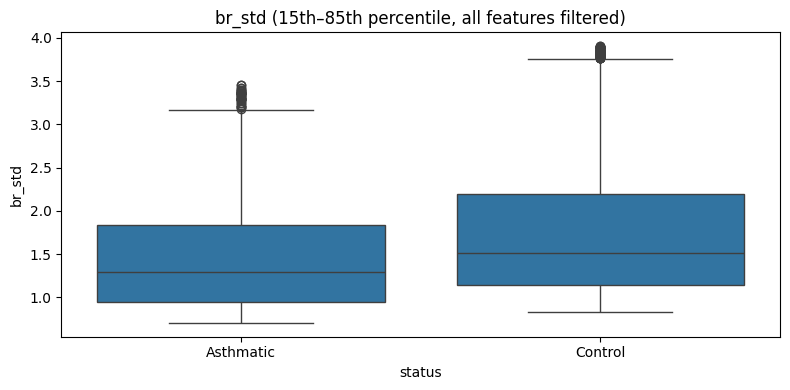

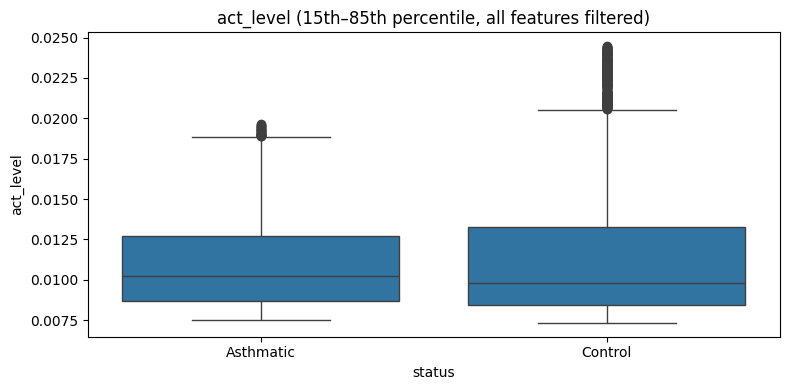

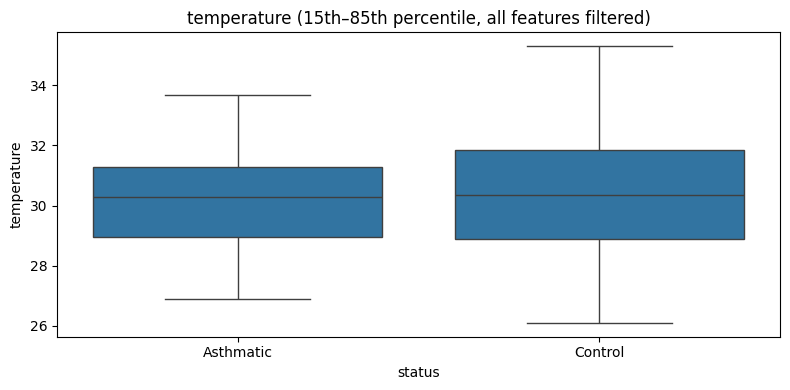

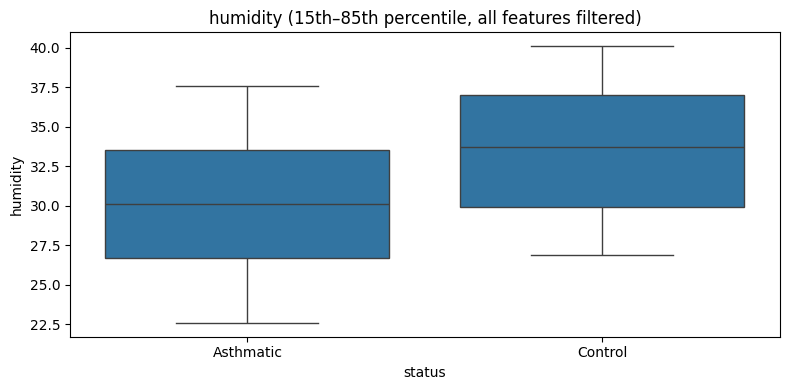

In [ ]:
## Using the same meta_clustered dataframe but now understanding distribution healthy vs ashmatic
avsh_data = meta_clustered.copy()

# Adding status if not already done
avsh_data['status'] = np.where(avsh_data['patient_id'].str.startswith('INH0'),'Asthmatic','Control')
print(avsh_data.groupby('status')['patient_id'].nunique())
print(avsh_data["status"].value_counts())

filtered = []

# Looping over 'Asthmatic' and 'Control'
for status, group in avsh_data.groupby('status'):
    # For each feature, only includind 15th–85th percentile range
    # This is to remove outliers
    for col in features:
        q_low = group[col].quantile(0.15)
        q_high = group[col].quantile(0.85)
        group = group[(group[col] >= q_low) & (group[col] <= q_high)]
    filtered.append(group)

# Combine back Asthmatic + Control into one filtered dataset
avsh_data_filtered = pd.concat(filtered)

# Plot distributions
for col in features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='status', y=col, data=avsh_data_filtered)
    plt.title(f"{col} (15th–85th percentile, all features filtered)")
    plt.tight_layout()
    plt.show()

# ## The data is basically skewed!!! Higher level of pollution, acitivty and inhalation from individuals leading to greater physiological response.
# ## Also more males and higher proportion of commuter with higher activity level

## Perturbation higher level of pollution %

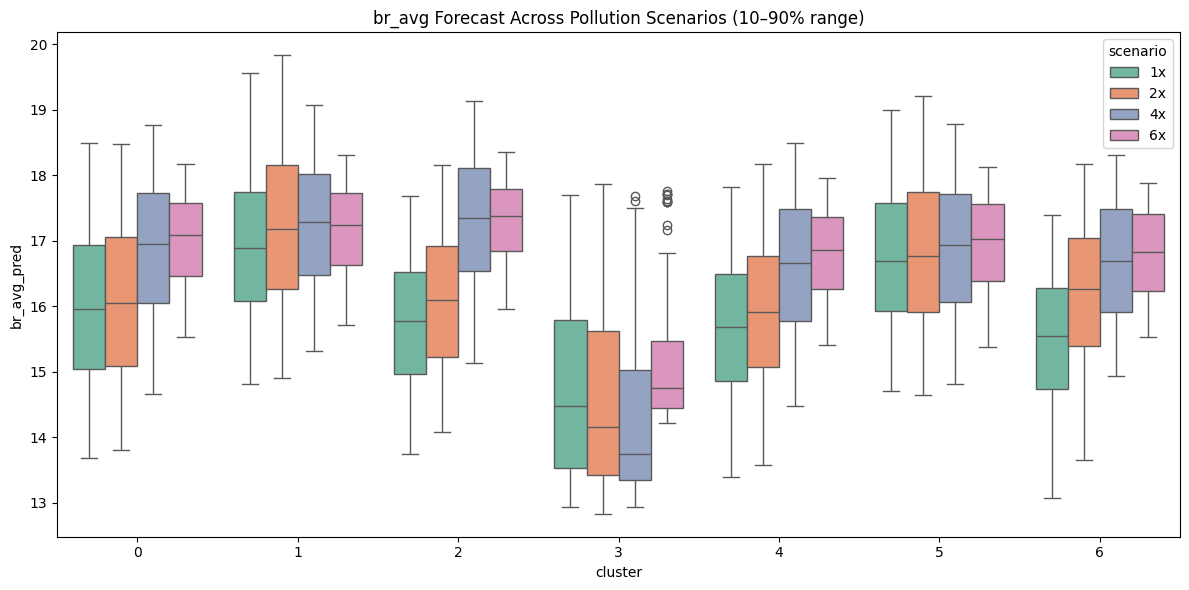

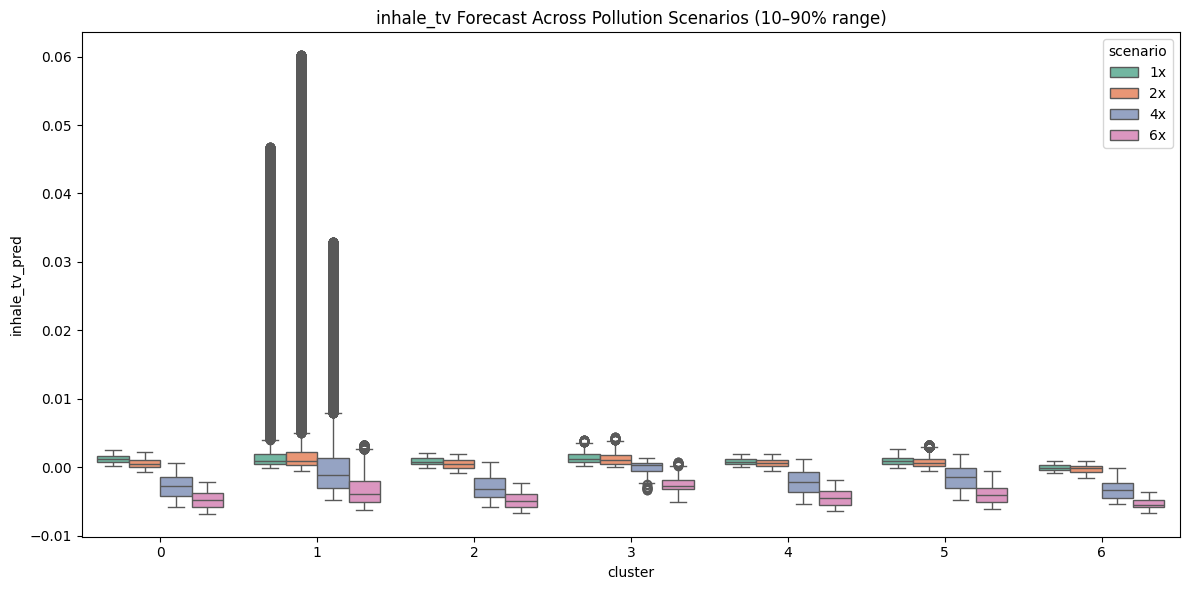

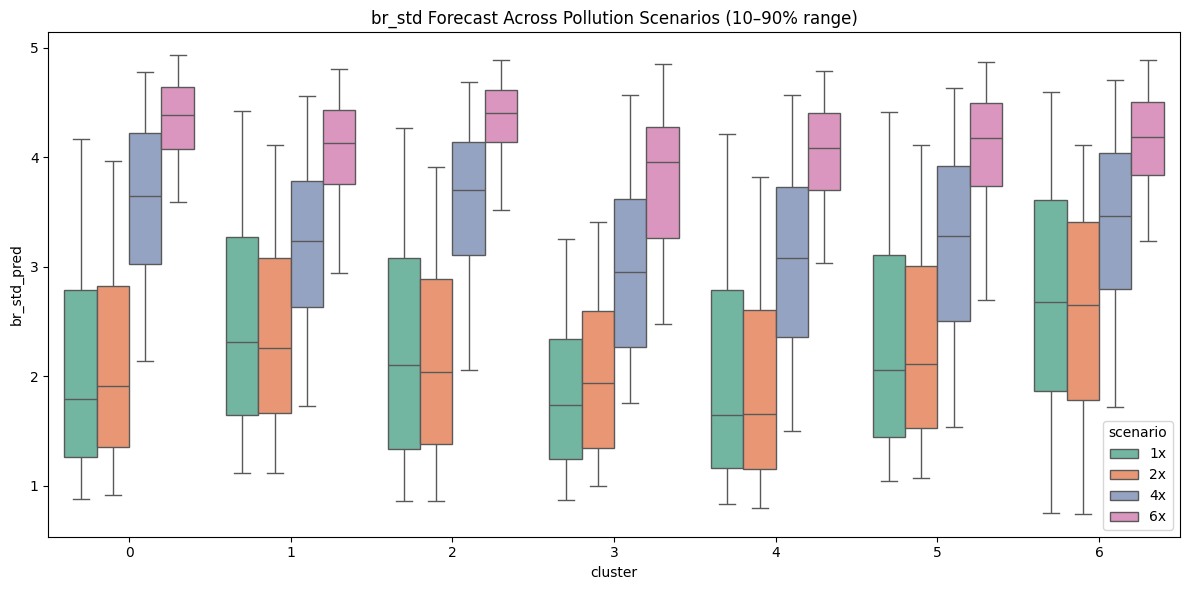

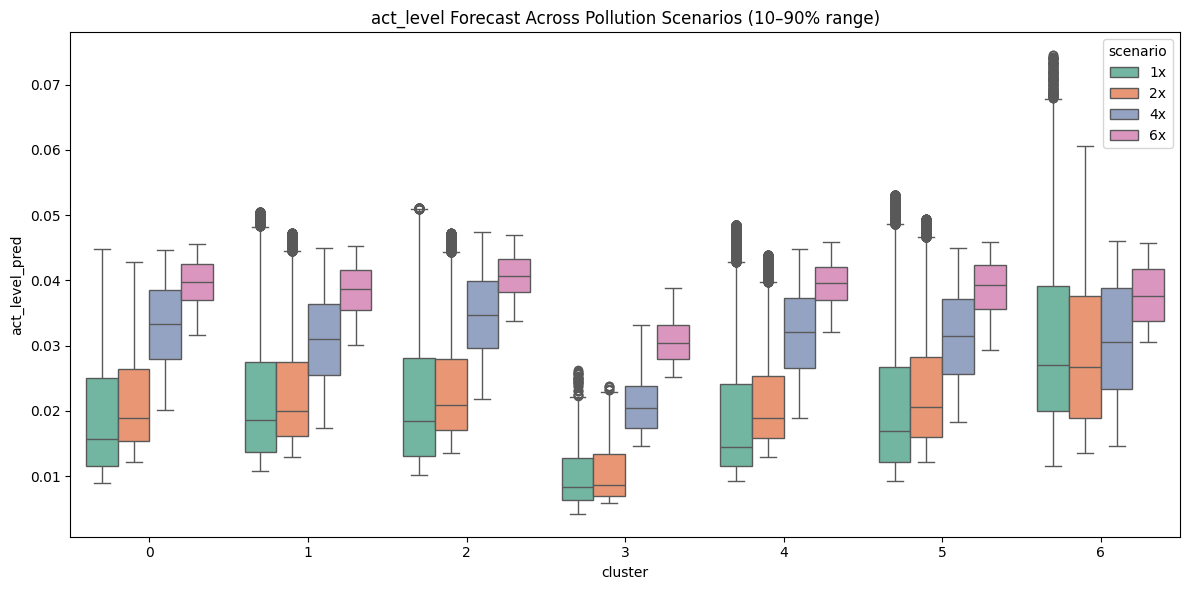

In [ ]:
## Selecting physiological and pollution columns
pollution_cols      = ['pm2_5_x','pm10','no','no2','o3','so2','co']
physiological_cols  = ['br_avg','inhale_tv','br_std','act_level']
forecast_steps      = 12
window_size         = window_size
multipliers         = [1, 2, 4, 6]
n_clusters          = 7

# Clustering patients from original data
baseline_dataset_pert = PatientLatentDataset(combined, feature_cols, scaler, window_size, forecast_steps)
baseline_loader_pert  = DataLoader(baseline_dataset_pert, batch_size=64, shuffle=False)

# Extracting latent vectors
z_df_pert, z_meta_df_pert = extract_latents_by_condition(model, baseline_loader_pert, device)
z_df_pert['patient_id'] = z_meta_df_pert['patient_id']

# Averaging latent representation per patient
agg_all_pert = z_df_pert.groupby('patient_id').mean()

# Scaling and cluster
X_scaled_pert = StandardScaler().fit_transform(agg_all_pert)
kmeans_pert   = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
agg_all_pert['cluster'] = kmeans_pert.fit_predict(X_scaled_pert)

# Keep patient_id for merging later
agg_all_indexed = agg_all_pert.reset_index()

# Predicting under pollution multipliers
all_preds = [predict_pollution_level(combined, m, model, feature_cols, scaler, window_size, forecast_steps,
                            pollution_cols, physiological_cols, device, PatientLatentDataset)for m in multipliers]

df_all    = pd.concat(all_preds, ignore_index=True)

# Merging clusters back
df_all = df_all.merge(agg_all_indexed[['patient_id','cluster']],on='patient_id',how='left')

# Plotting with IQR outlier removal
for col in [f'{c}_pred' for c in physiological_cols]:

    filtered_groups = []
    for (cluster, scenario), group in df_all.groupby(['cluster','scenario']):
        q1, q9 = group[col].quantile([0.10, 0.90])
        filtered_groups.append(group[(group[col] >= q1) & (group[col] <= q9)])

    filtered = pd.concat(filtered_groups, ignore_index=True)

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='cluster', y=col, hue='scenario', data=filtered, palette='Set2')
    plt.title(f"{col.replace('_pred','')} Forecast Across Pollution Scenarios (10–90% range)")
    plt.tight_layout()
    plt.show()

In [ ]:
metrics = ['br_avg_pred','br_std_pred']

sub = df_all[df_all['scenario'].isin(['1x','6x'])].copy()

tables = []
for col in metrics:
    m = (sub.pivot_table(index='cluster', columns='scenario', values=col, aggfunc='median')
           .reindex(columns=['1x','6x']))
    tbl = pd.DataFrame({
        '1x median': m['1x'],
        '6x median': m['6x'],
        'Δ(6x−1x)': m['6x'] - m['1x'],
        '%Δ(6x vs 1x)': (m['6x'] - m['1x']) / m['1x'] * 100
    })
    tbl.columns = pd.MultiIndex.from_product([[col], tbl.columns])
    tables.append(tbl)

final = pd.concat(tables, axis=1).round(2)
print(final)

        br_avg_pred                                  br_std_pred            \
          1x median  6x median Δ(6x−1x) %Δ(6x vs 1x)   1x median 6x median   
cluster                                                                      
0         15.960000  17.080000     1.12         7.03        1.79      4.39   
1         16.889999  17.240000     0.35         2.06        2.31      4.13   
2         15.770000  17.379999     1.60        10.17        2.10      4.41   
3         14.480000  14.750000     0.27         1.87        1.73      3.96   
4         15.680000  16.860001     1.17         7.48        1.65      4.09   
5         16.690001  17.020000     0.33         1.96        2.06      4.18   
6         15.540000  16.830000     1.29         8.31        2.68      4.19   

                               
        Δ(6x−1x) %Δ(6x vs 1x)  
cluster                        
0           2.59   144.580002  
1           1.82    78.610001  
2           2.31   110.010002  
3           2.23   128.5200

## Now Applying to one individual only

In [ ]:
# Maintaining the same configuration of the genral model just appllied to one individual only
sampling_interval = 60    # minutes per row
history_hours     = 1     # look back 1 h
forecast_hours    = 12    # forecast next 12 h
block_minutes     = 60    # we predict in 60 min chunks

# Same as above
window_size = history_hours * 60 // sampling_interval   # = 1
block_size  = block_minutes    // sampling_interval     # = 1
num_blocks  = (forecast_hours * 60) // block_minutes    # = 12
horizon     = block_size * num_blocks                   # = 12 rows ahead

print(f"window_size={window_size}, block_size={block_size}, "
      f"num_blocks={num_blocks}, horizon={horizon}")

# Scaling the unseen data with my already‐fitted scaler
val_data_nn_scaled = scaler.transform(val_data_nn_pre[feature_cols])

# Building exactly the same SlidingWindowDataset
val_dataset_individual = SlidingWindowDataset(
    data           = val_data_nn_scaled,
    window_size    = window_size,    # 1
    forecast_steps = horizon,        # 12
    step           = 1
)

val_loader_individual = DataLoader(
    val_dataset_individual,
    batch_size = batch_size,
    shuffle    = True,
)

# Preparing model and discriminator
fine_tune_model           = copy.deepcopy(model).to(device)
fine_tune_optimizer       = torch.optim.Adam(fine_tune_model.parameters(), lr=1e-3) ## it was 4
fine_tune_disc_optimizer  = torch.optim.Adam(discriminator.parameters(),   lr=1e-3) ## it was 5

# Fine-tuning with the same training method
train_model_aae_rollout(
    model                    = fine_tune_model,
    train_loader             = val_loader_individual,
    val_loader               = val_loader_individual,
    optimizer                = fine_tune_optimizer,
    discriminator            = discriminator,
    disc_optimizer           = fine_tune_disc_optimizer,
    device                   = device,
    epochs                   = 3,
    adv_weight               = 0.01,
    scheduled_sampling_start = 1.0,
    scheduled_sampling_end   = 0.5,
    scheduled_sampling_decay = 0.9,
    block_size               = block_size,   # 1
    num_blocks               = num_blocks    # 12
)

window_size=1, block_size=1, num_blocks=12, horizon=12
[Epoch 01] Train=0.019655 | Val=0.000830 | Disc=1.4517 | Adv=0.6716 | SampProb=1.000
[Epoch 02] Train=0.017758 | Val=0.000829 | Disc=1.4794 | Adv=0.6863 | SampProb=0.900
[Epoch 03] Train=0.018616 | Val=0.000842 | Disc=1.3738 | Adv=0.7272 | SampProb=0.810


VariationalTimeSeriesTransformer(
  (input_proj): Linear(in_features=22, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-2): 3 x CustomTransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (linear1): Linear(in_features=64, out_features=128, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=128, out_features=64, bias=True)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (mean_layer): Linear(in_features=64, out_features=64, bias=True)
  (logvar_layer): Linear(in_features=64, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bi

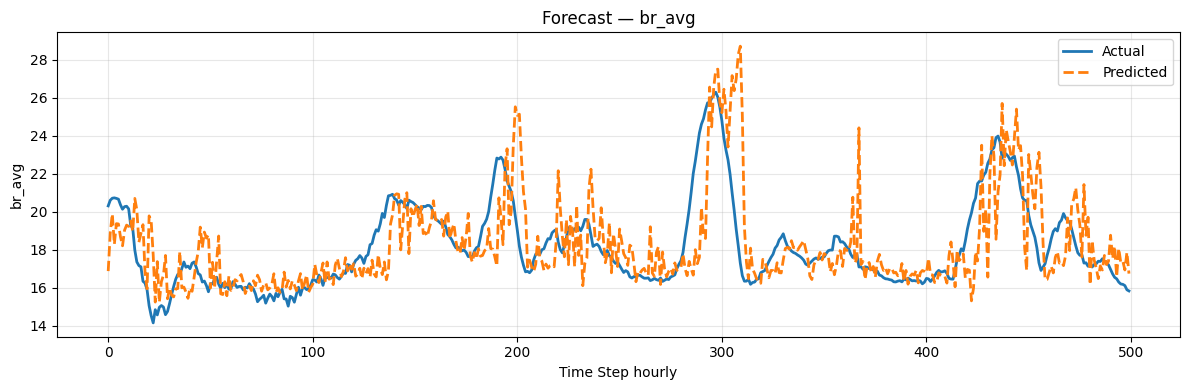

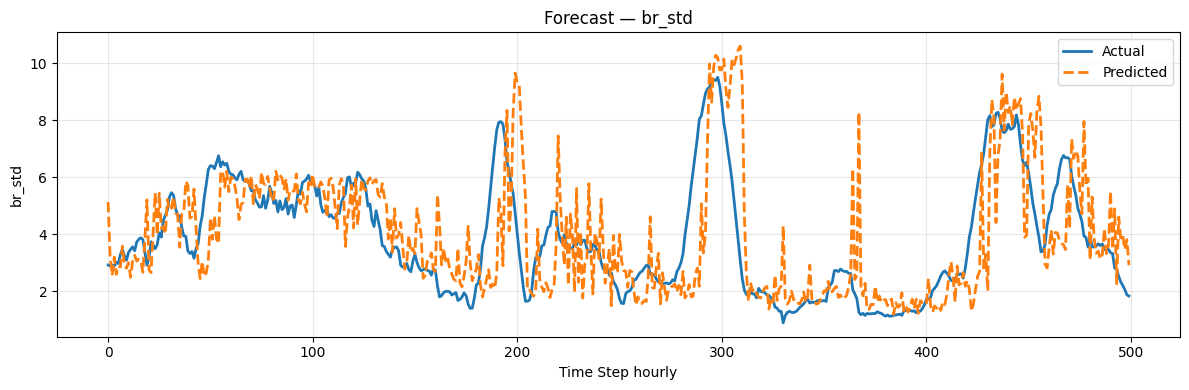

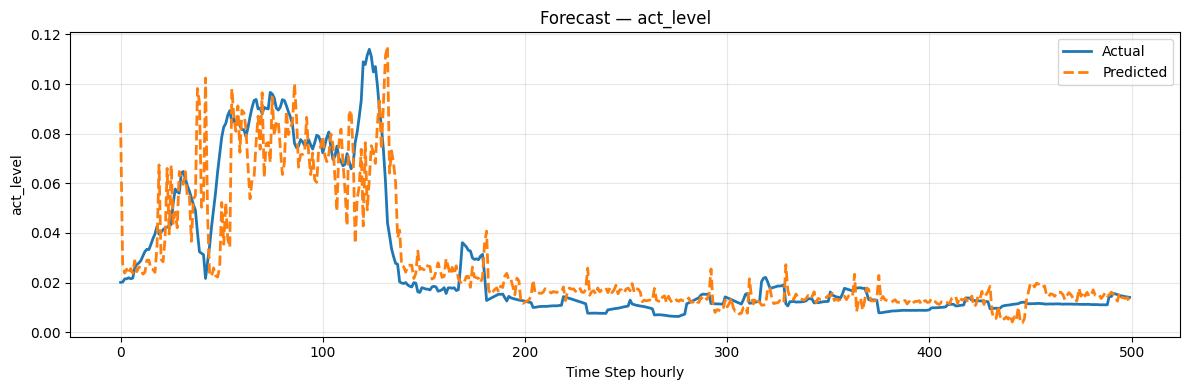

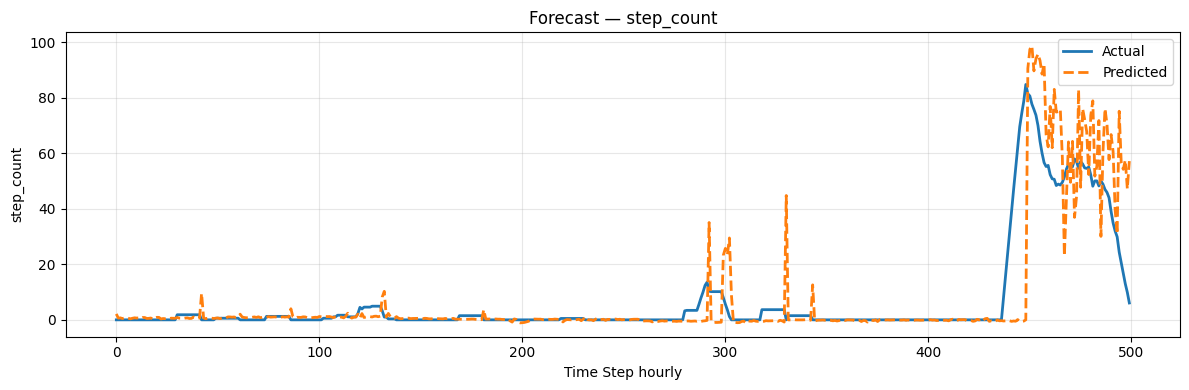

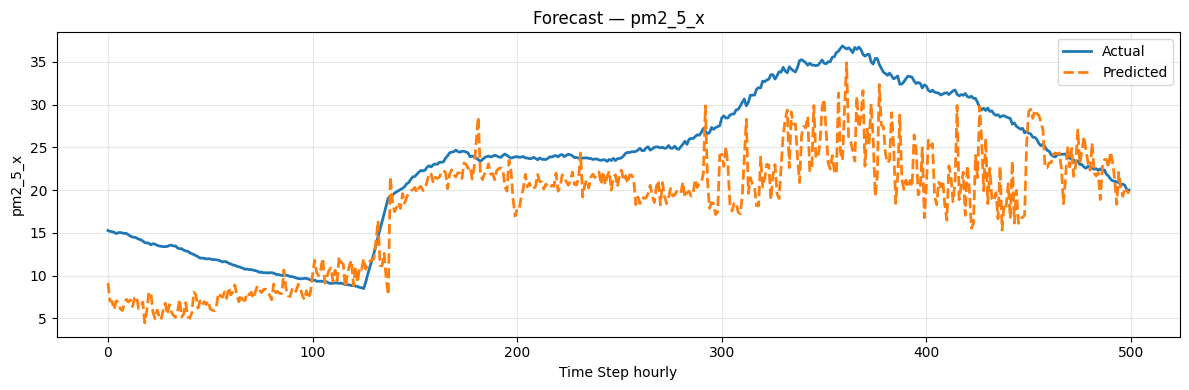

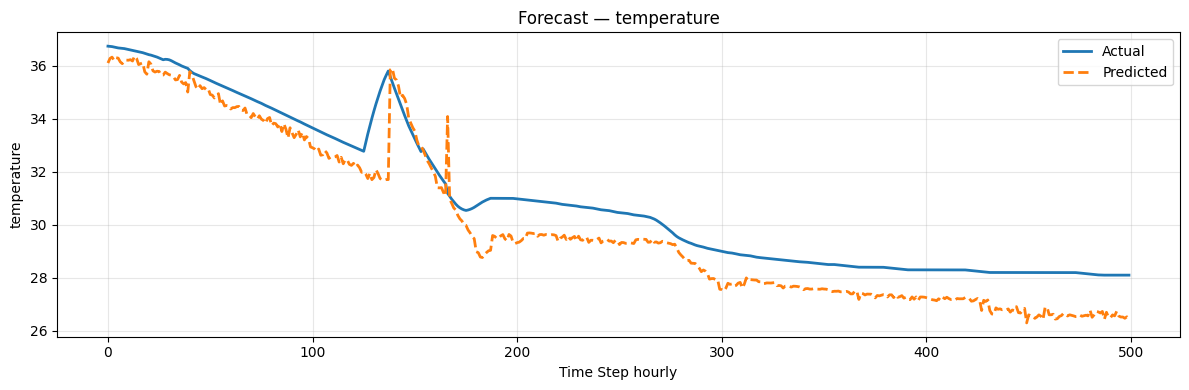

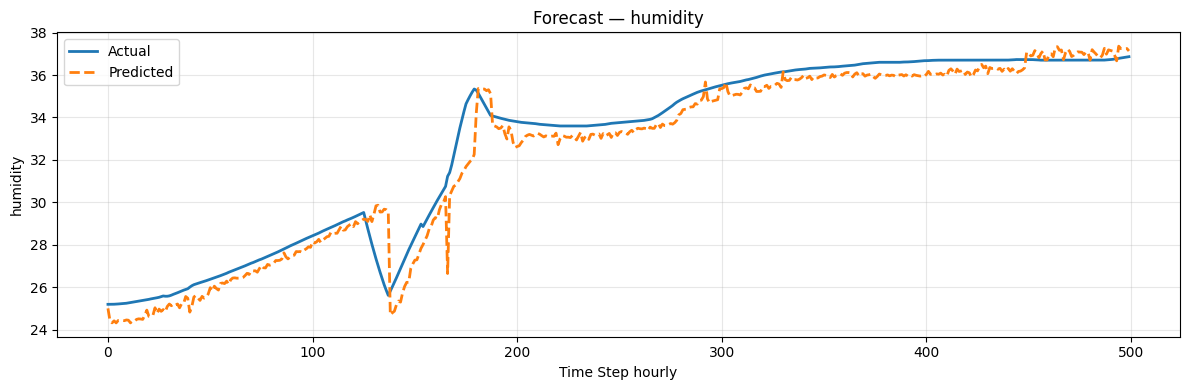

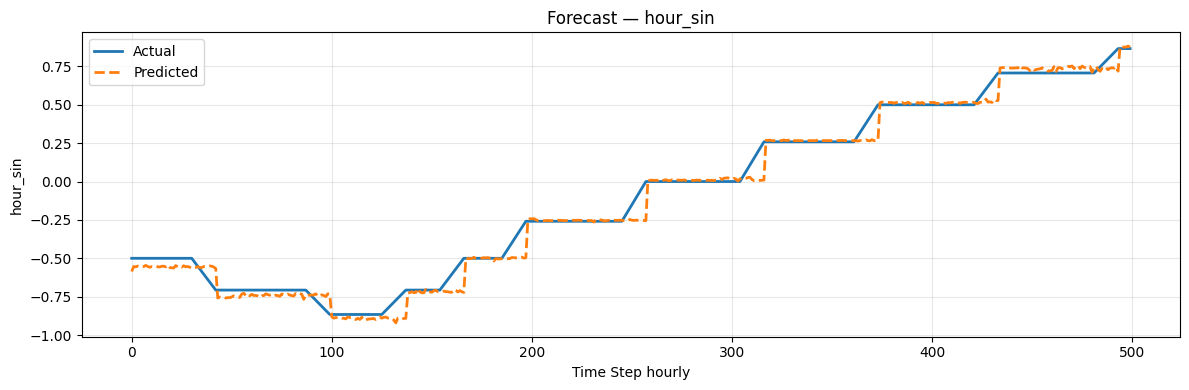

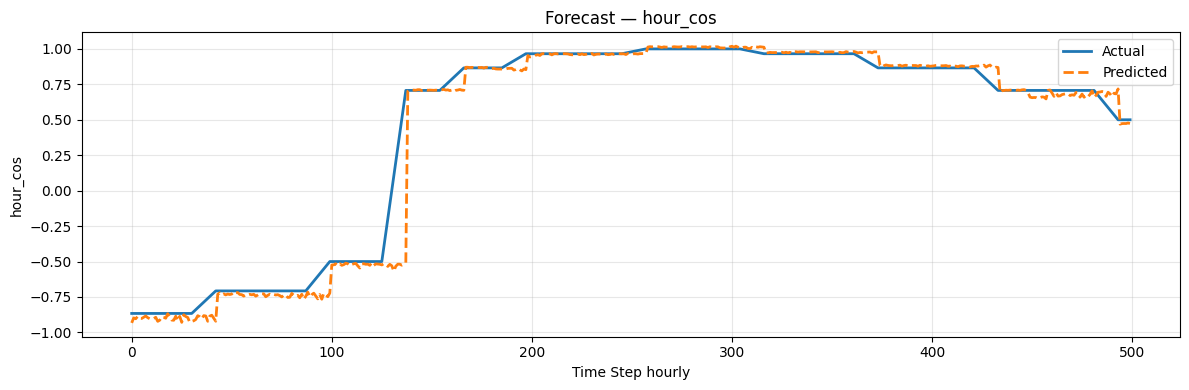

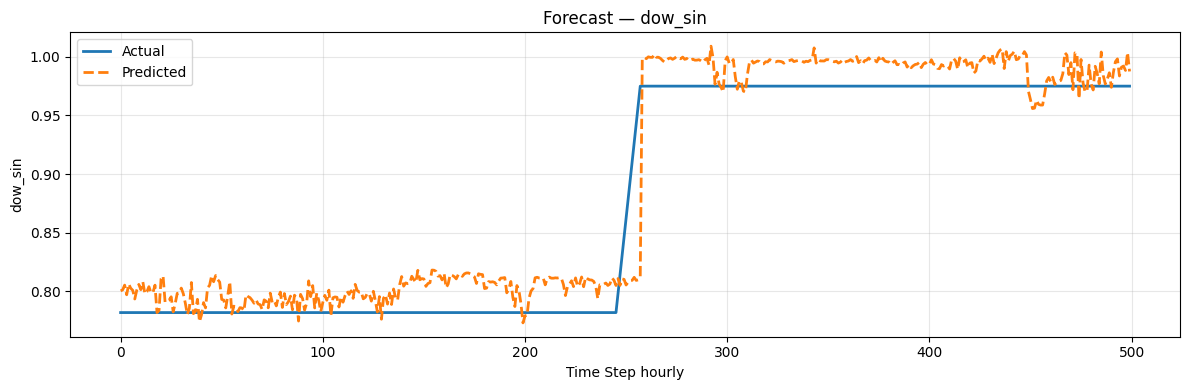

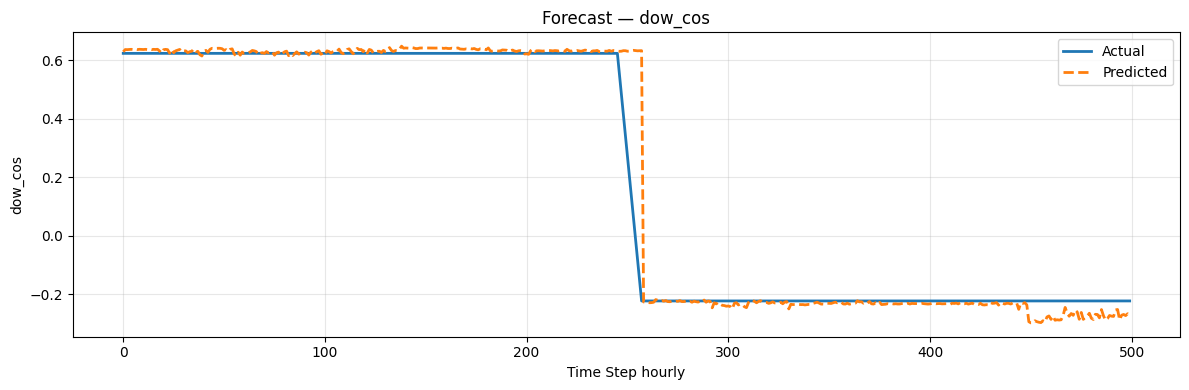

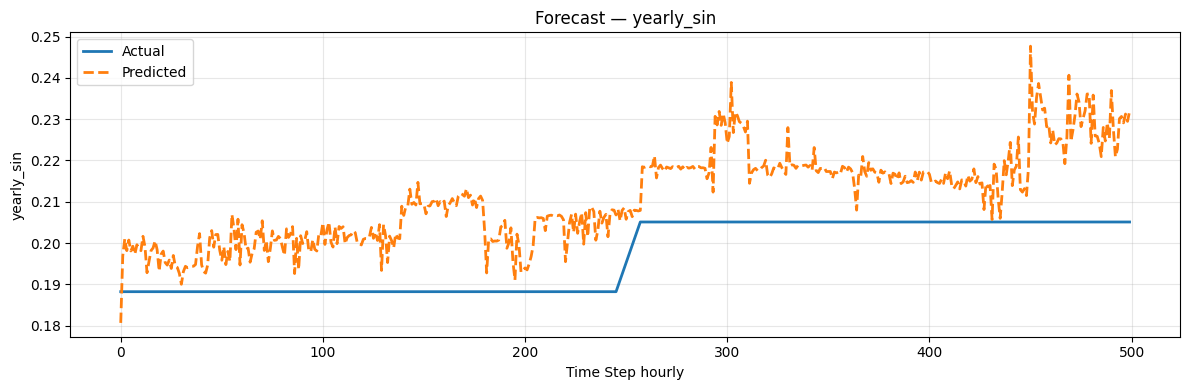

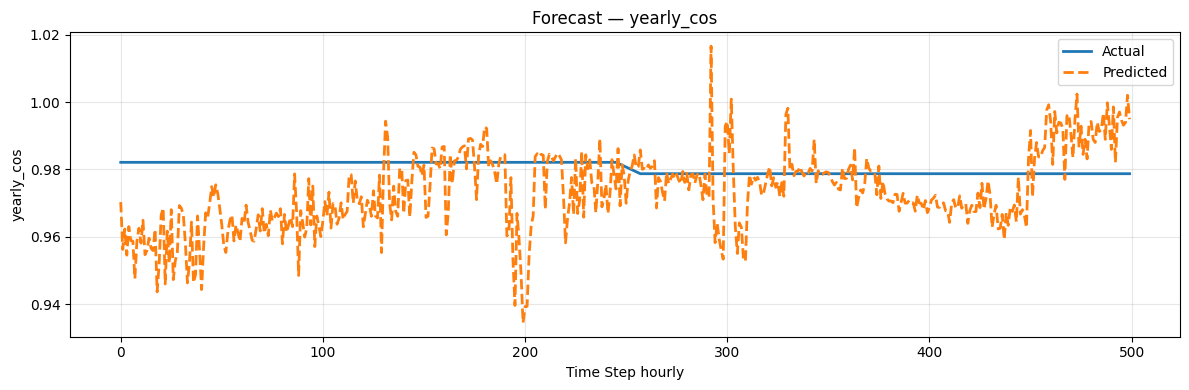

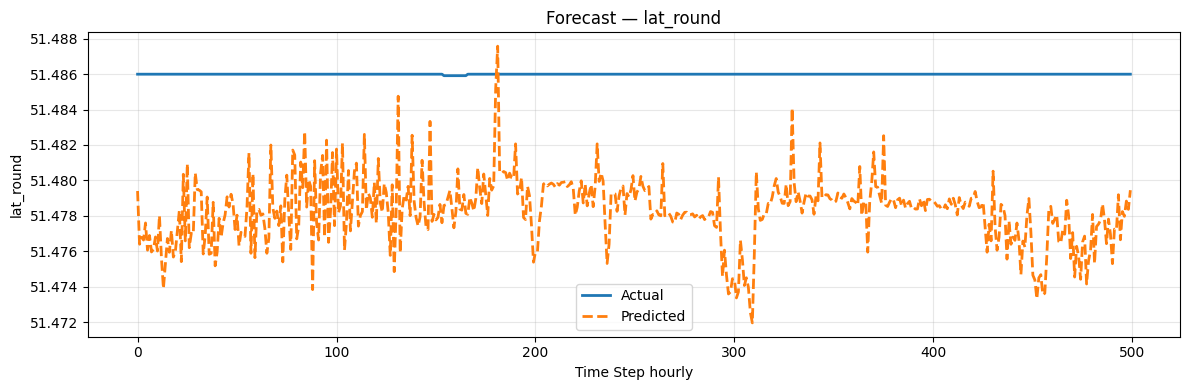

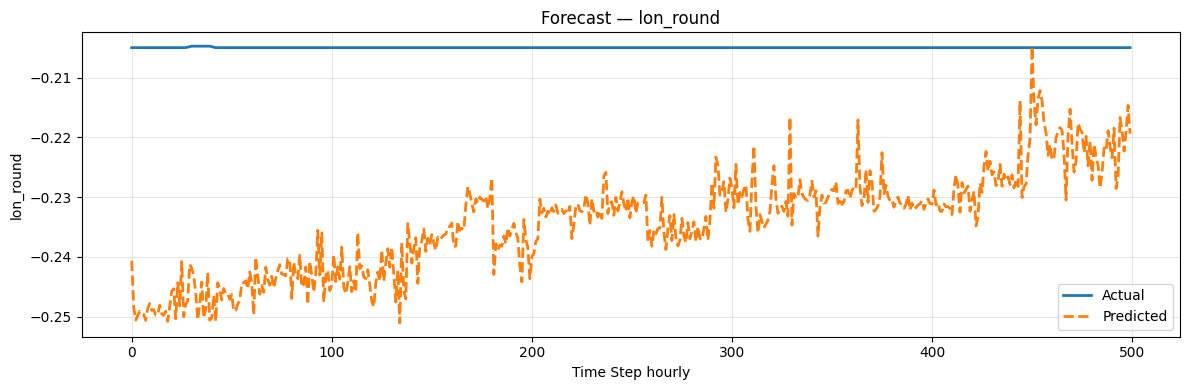

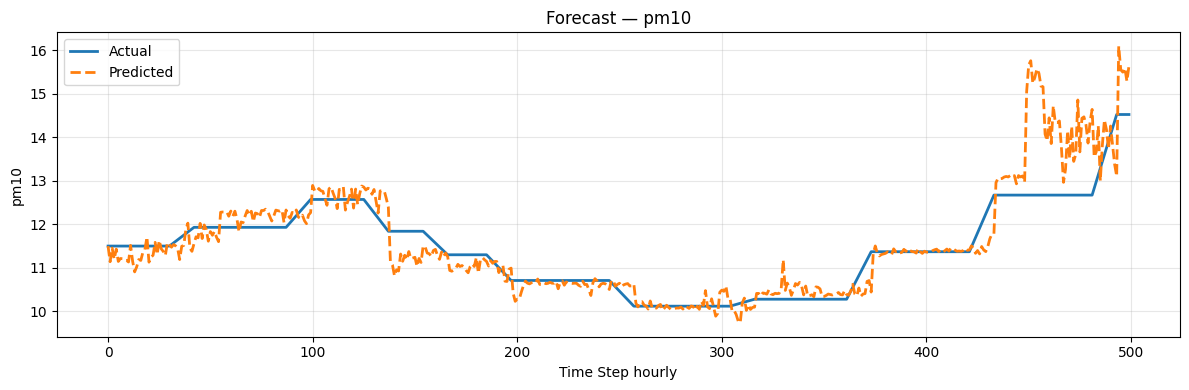

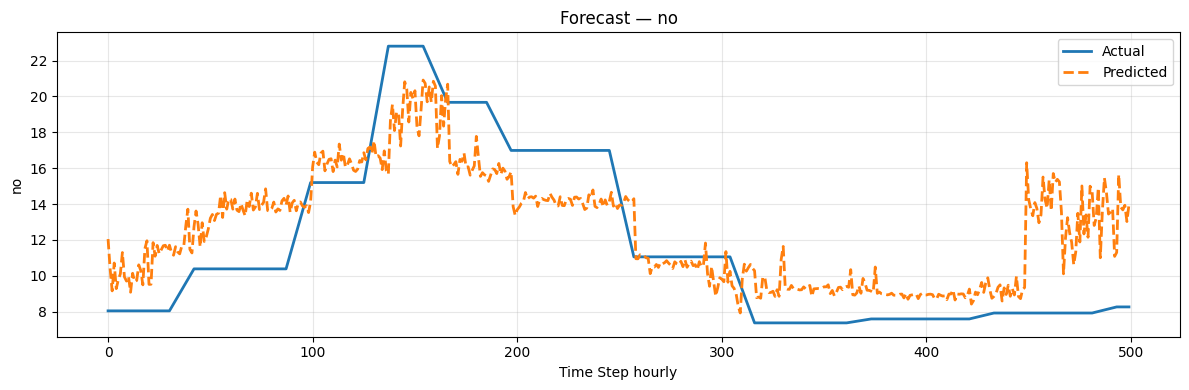

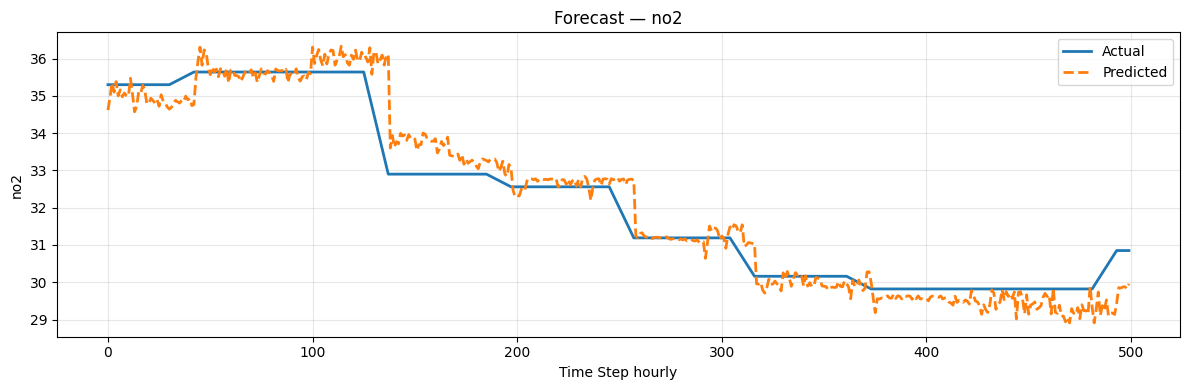

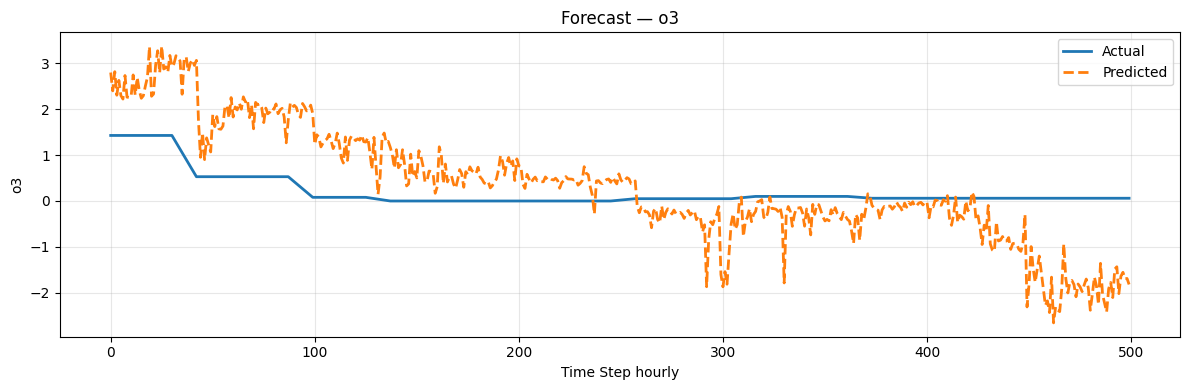

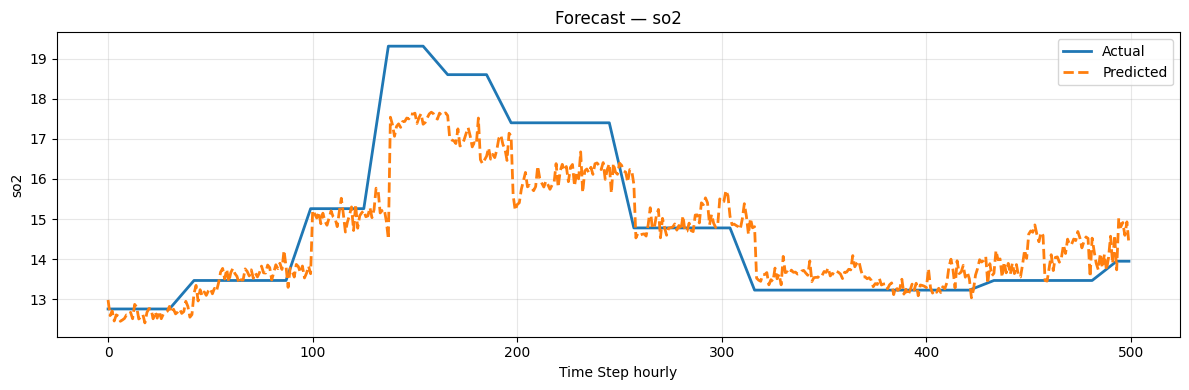

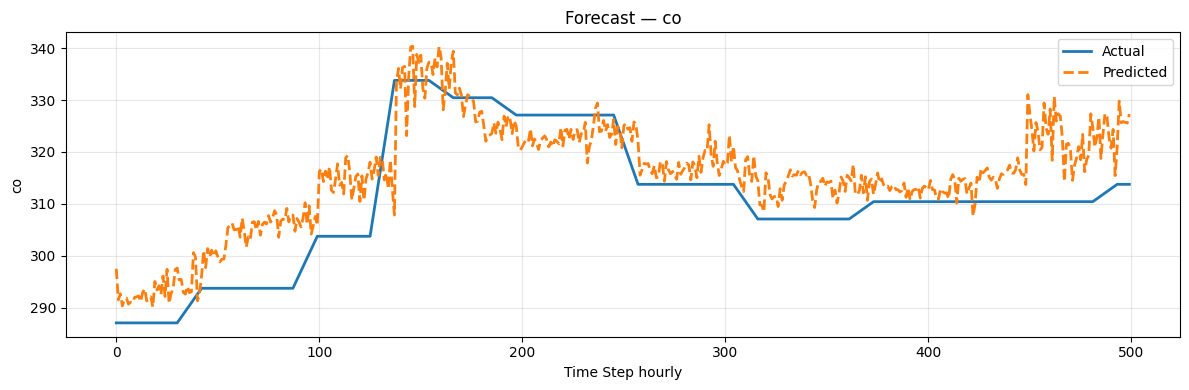

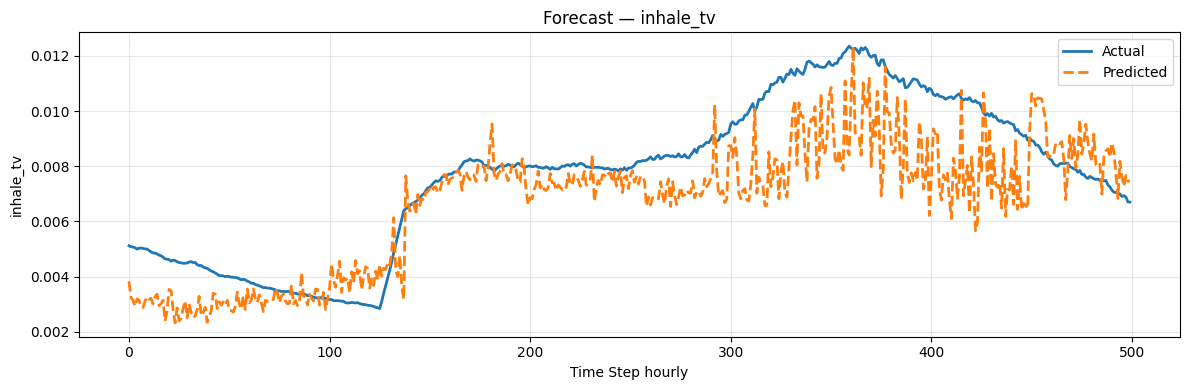

In [ ]:
# Creating val loader and then plotting to see predictions!
val_loader_individual = DataLoader(val_dataset_individual, batch_size=batch_size, shuffle=False)

preds_h, trues_h = evaluate_individual_hourly_forecast(
    model=fine_tune_model,
    dataloader=val_loader_individual,
    device=device,
    scaler=scaler,
    feature_names=feature_cols,
    scaler_feature_order=getattr(scaler, "feature_names_in_", None),  # or pass the exact list
    horizon_reduce="mean",
    sampling_interval=60,
    aggregate_to_minutes=None,
    plot_n=500
)

## FULL Threshold

In [ ]:
# Get baseline prediction vector (per-person)

# Defining risk-relevant features ----
risk_features = ['br_avg', 'br_std', 'act_level', 'pm10', 'no2', 'o3', 'pm2_5_x', 'so2']
risk_indices = [feature_cols.index(f) for f in risk_features]

baseline_pred_vector = get_baseline_prediction_vector(model=fine_tune_model,dataloader=val_loader_individual,device=device,scaler=scaler,risk_indices=risk_indices)
# Scanning and classifying risk
risks, distances = scan_individual_risk(model=fine_tune_model,dataset=val_dataset_individual,scaler=scaler,baseline_vector=baseline_pred_vector,risk_indices=risk_indices,device=device)

## THRESHOLD FILTERED by pollutant

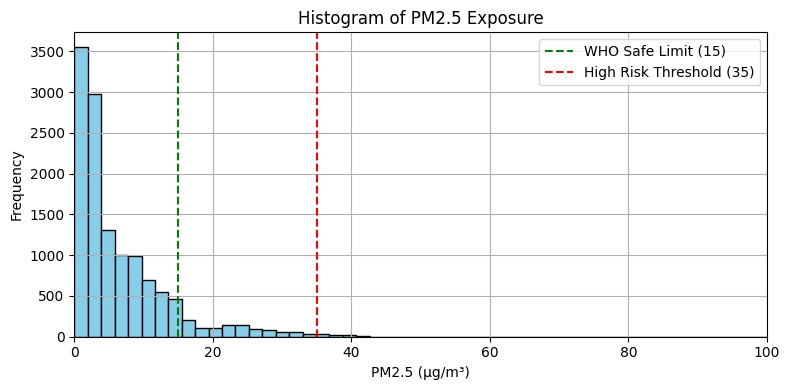

In [ ]:
x = val_data_nn_pre["pm2_5_x"]
plt.figure(figsize=(8, 4))
plt.hist(x, bins=500, color='skyblue', edgecolor='black')
plt.axvline(15, color='green', linestyle='--', label='WHO Safe Limit (15)')
plt.axvline(35, color='red', linestyle='--', label='High Risk Threshold (35)')
plt.title("Histogram of PM2.5 Exposure")
plt.xlabel("PM2.5 (μg/m³)")
plt.ylabel("Frequency")
plt.xlim(0, 100)  #  Limits x-axis so extreme outliers don't ruin visibility
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 Reactivity Report:
• Low pollution (≤ 1.38) deviation: 0.2389
• High pollution (> 7.13) deviation: 0.3124
• Reactivity Score: 0.0735


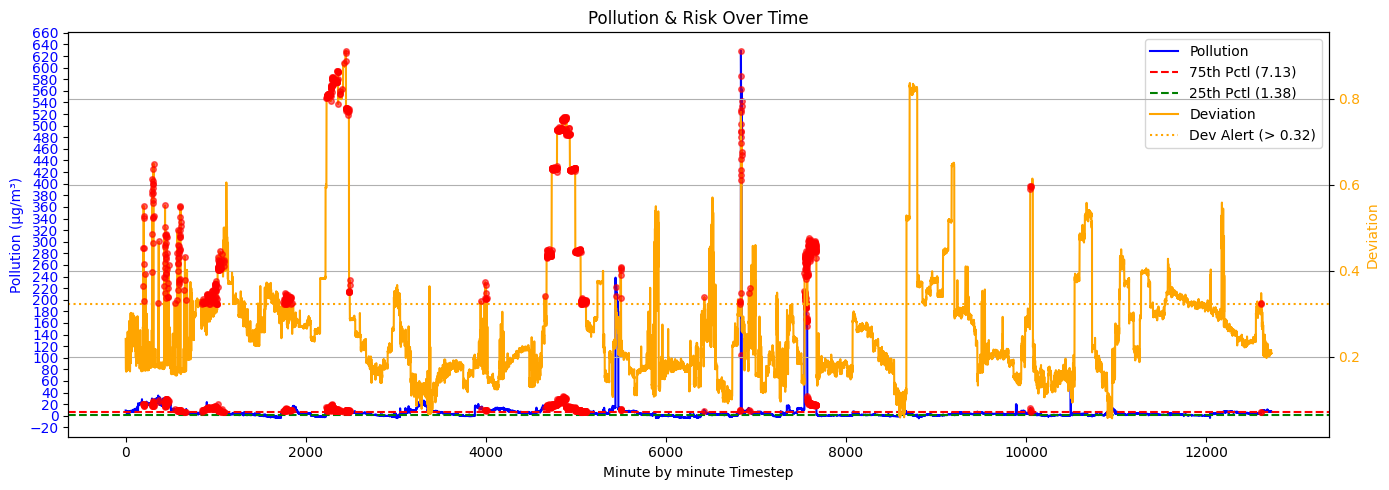

In [ ]:
## Threshold alert system

pollution_var   = "pm2_5_x"
risk_features   = ['br_avg','br_std','act_level','pm10','no2','o3','pm2_5_x','so2']
pollution_idx   = feature_cols.index(pollution_var)
risk_indices    = [feature_cols.index(f) for f in risk_features]

# Baseline + deviations
baseline = get_baseline_prediction_vector(model=fine_tune_model,dataloader=val_loader_individual,device=device,scaler=scaler,risk_indices=risk_indices)
deviations, pollution_vals = scan_risk(model=fine_tune_model,dataset=val_dataset_individual,scaler=scaler,baseline_vector=baseline,risk_indices=risk_indices,pollution_index=pollution_idx,device=device)

# Reactivity summary
avg_low, avg_high, score, (low_th, high_th) = compute_reactivity_score(deviations, pollution_vals)

print("\n Reactivity Report:")
print(f"• Low pollution (≤ {low_th:.2f}) deviation: {avg_low:.4f}")
print(f"• High pollution (> {high_th:.2f}) deviation: {avg_high:.4f}")
print(f"• Reactivity Score: {score:.4f}")

## alert detection system
dev_th = np.percentile(deviations, 75)

alerts = []
for i, (p, d) in enumerate(zip(pollution_vals, deviations)):
    if p > high_th and d > dev_th:
        alerts.append((i, p, d))

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 5))
ax2 = ax1.twinx()

# Pollution axis
ax1.set_xlabel("Minute by minute Timestep")
ax1.set_ylabel("Pollution (µg/m³)", color="blue")
ax1.plot(pollution_vals, color="blue", label="Pollution", lw=1.5)
ax1.axhline(high_th, color="red", ls="--", label=f"75th Pctl ({high_th:.2f})")
ax1.axhline(low_th,  color="green", ls="--", label=f"25th Pctl ({low_th:.2f})")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.yaxis.set_major_locator(MultipleLocator(20))

# Deviation axis
ax2.set_ylabel("Deviation", color="orange")
ax2.plot(deviations, color="orange", label="Deviation", lw=1.5)
ax2.axhline(dev_th, color="orange", ls=":", label=f"Dev Alert (> {dev_th:.2f})")
ax2.tick_params(axis="y", labelcolor="orange")

# Alerts
for i, p, d in alerts:
    ax1.plot(i, p, "ro", ms=4, alpha=0.6)
    ax2.plot(i, d, "ro", ms=4, alpha=0.6)

# Layout
plt.title("Pollution & Risk Over Time")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")
plt.grid(True)
fig.tight_layout()
plt.show()